## Imports

### Install font and other packages

In [100]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [101]:
pip install git+https://github.com/quantopian/pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-rbl4p51w
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-rbl4p51w


In [102]:
pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Packages

In [103]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import homogeneity_score,completeness_score,v_measure_score
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

import matplotlib.ticker as ticker
from itertools import cycle

import pandas_datareader.naver as web_naver

In [104]:
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
idx = pd.IndexSlice

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 
# 유니코드에서  음수 부호설정
plt.rc('axes', unicode_minus=False)
np.random.seed(42)

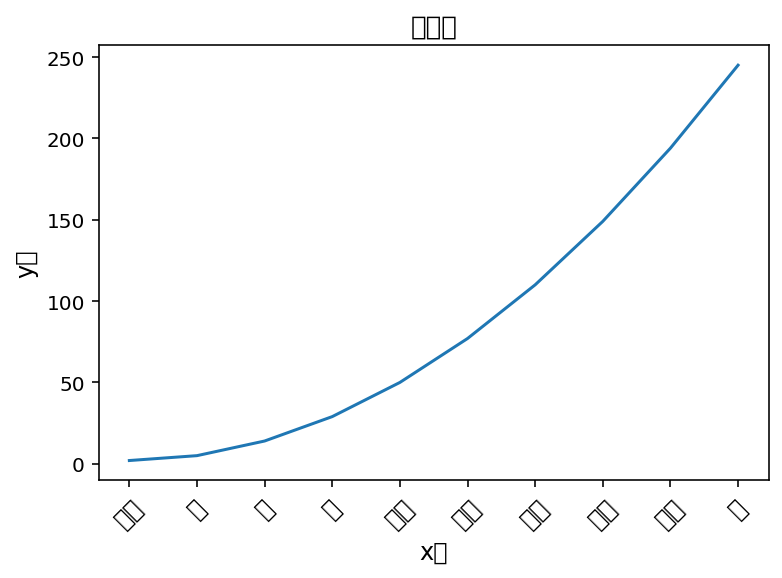

In [105]:
plt.plot([x for x in range(0, 10)], [(3*y**2)+2 for y in range(0, 10)])
plt.title("예제다", fontsize= 13)
plt.xlabel("x축", fontsize= 12)
plt.xticks(np.arange(0, 10, 1), ['하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '열'], fontsize= 12, rotation= 45)
plt.ylabel("y축", fontsize= 12)
plt.show()

### Import data

In [106]:
krx100 = pd.read_csv('KRX100.csv', encoding='cp949')
krx100.head()

종목코드       종목명      종가    대비   등락률       상장시가총액
0    5930      삼성전자   60000  2500  4.35  358186953.0
1  373220  LG에너지솔루션  400000   500  0.13   93600000.0
2     660    SK하이닉스   98700  4700  5.00   71853833.0
3  207940  삼성바이오로직스  817000 -8000 -0.97   58149158.0
4    5380       현대차  183500  1000  0.55   39208112.0

In [107]:
krx300 = pd.read_csv('KRX300.csv', encoding='cp949')
krx300.head()

종목코드       종목명      종가    대비   등락률       상장시가총액
0    5930      삼성전자   60000  2500  4.35  358186953.0
1     660    SK하이닉스   98700  4700  5.00   71853833.0
2  207940  삼성바이오로직스  817000 -8000 -0.97   58149158.0
3    5380       현대차  183500  1000  0.55   39208112.0
4   35420     NAVER  231000 -2500 -1.07   37895339.0

In [108]:
kospi200 = pd.read_csv('KOSPI200.csv', encoding='cp949')
kospi200.head()

종목코드       종목명      종가    대비   등락률       상장시가총액
0    5930      삼성전자   60000  2500  4.35  358186953.0
1  373220  LG에너지솔루션  400000   500  0.13   93600000.0
2     660    SK하이닉스   98700  4700  5.00   71853833.0
3  207940  삼성바이오로직스  817000 -8000 -0.97   58149158.0
4    5380       현대차  183500  1000  0.55   39208112.0

In [109]:
kosdaq150 = pd.read_csv('KOSDAQ150.csv', encoding='cp949')
kosdaq150.head()

종목코드       종목명      종가    대비   등락률      상장시가총액
0   91990  셀트리온헬스케어   70500  -800 -1.12  11149919.0
1  247540    에코프로비엠  111500 -5500 -4.70  10904850.0
2   66970      엘앤에프  207500 -5500 -2.58   7455395.0
3   28300       HLB   42800   250  0.59   4574581.0
4  293490    카카오게임즈   49400 -2100 -4.08   3887740.0

In [110]:
start = datetime.datetime(2012,1,1)
end = datetime.datetime(2022,6,30)
#dataset = pd.concat([kospi200, kosdaq150], axis=0)
#dataset = krx100
dataset = krx300

In [111]:
def import_price_data(start, end, dataset):
    dictionary = {}
    code_list = dataset['종목코드'].tolist()
    name_list = dataset['종목명'].tolist()
    for i in tqdm(range(len(code_list))):
        code = str(code_list[i]).zfill(6)
        name = name_list[i]
        df = web_naver.NaverDailyReader(symbols=code, start=start, end=end, adjust_price=True).read()
        adj_close = df.Close
        dictionary[name] = adj_close
    data = pd.DataFrame(dictionary)
    data = data.astype('float')
    return data

In [112]:
df = import_price_data(start, end, dataset)

100%|██████████| 300/300 [05:36<00:00,  1.12s/it]


In [113]:
# 5% 이상의 결측치가 존재하면 그 종목은 사용하지 않기로 한다.
def dropna_percent(percentage, dataset):
    print('결측치 존재 여부: ', dataset.isnull().values.any())
    missing_fraction = dataset.isnull().mean().sort_values(ascending=False)
    drop_list = sorted(list(missing_fraction[missing_fraction > percentage].index))
    new_df = dataset.drop(labels=drop_list, axis=1)
    print(f"제거한 column의 수는 {len(drop_list)}개 입니다.")
    return new_df

In [114]:
df = dropna_percent(0.05, df)

결측치 존재 여부:  True
제거한 column의 수는 92개 입니다.


In [115]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
print(df.shape)
print('결측치 존재 여부: ', df.isnull().values.any())

(2584, 208)
결측치 존재 여부:  False


In [116]:
train = df[df.index <= '2020-01-20']
test = df[df.index > '2020-01-20']

## Data Transformation and Use Clustering Algorithm

### Data Transformation

In [117]:
returns = train.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = train.pct_change().std() * np.sqrt(252)
data=returns

In [118]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset
X.head(2)

Returns  Volatility
삼성전자    0.290785   -1.143709
SK하이닉스  0.739687   -0.417768

### K-means

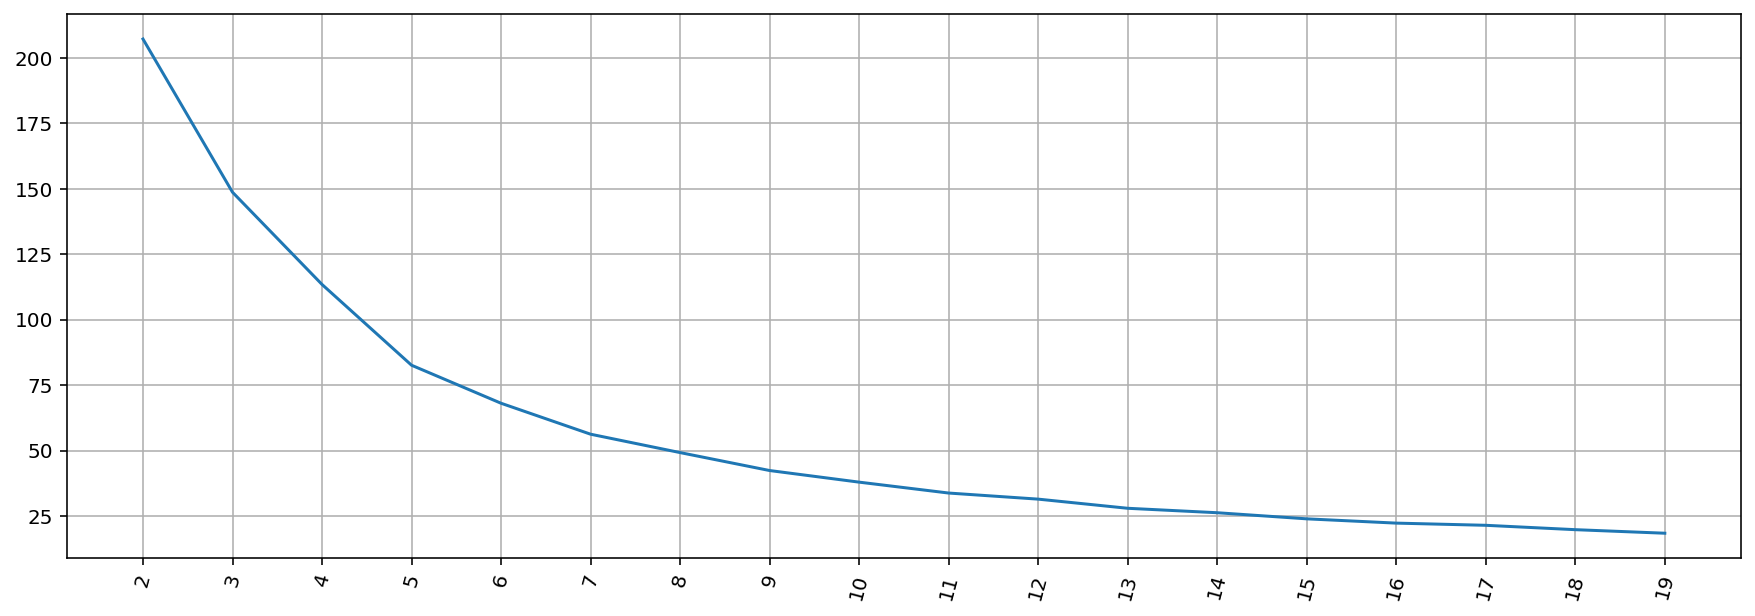

In [119]:
# 군집 내 SSE 값
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

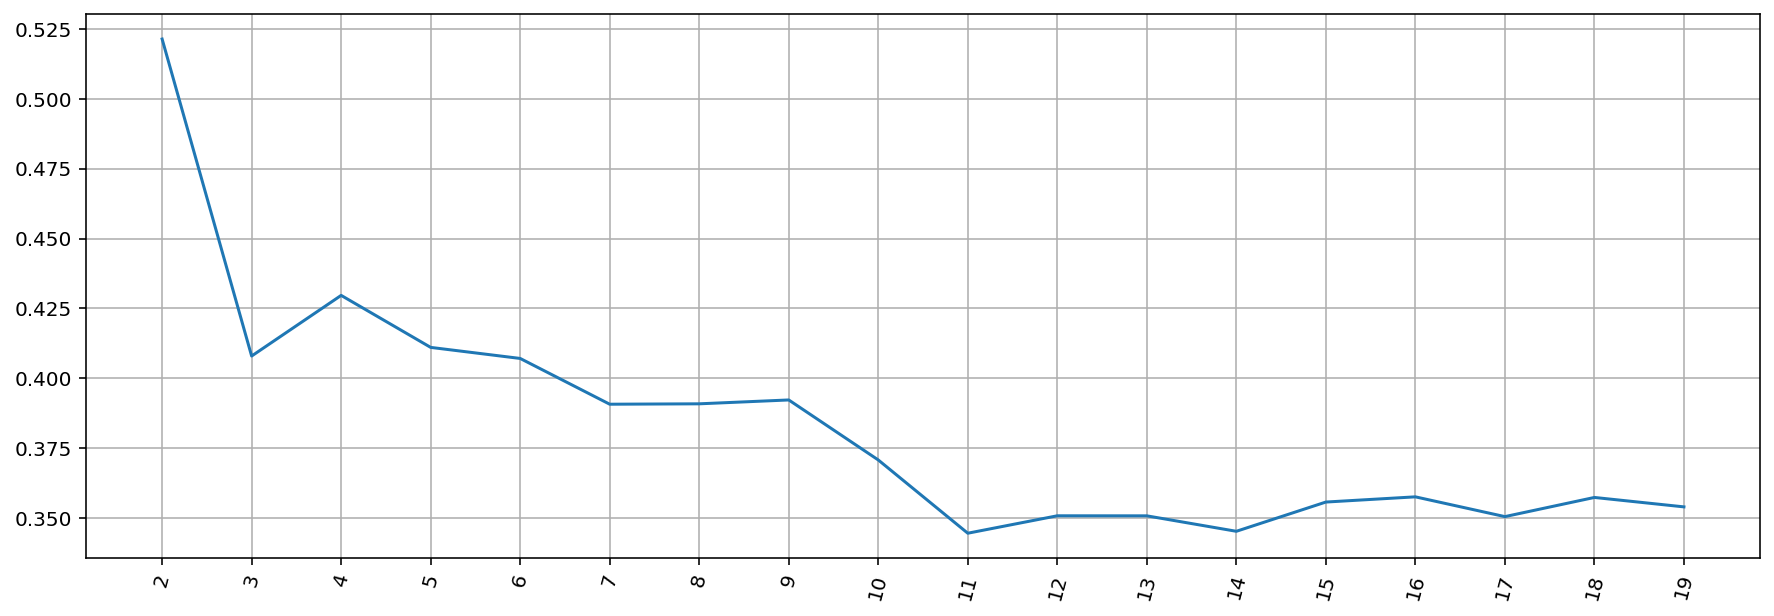

In [120]:
# 실루엣 계수
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

In [121]:
nclust=4

k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(n_clusters=4)

In [122]:
target_labels = k_means.predict(X)

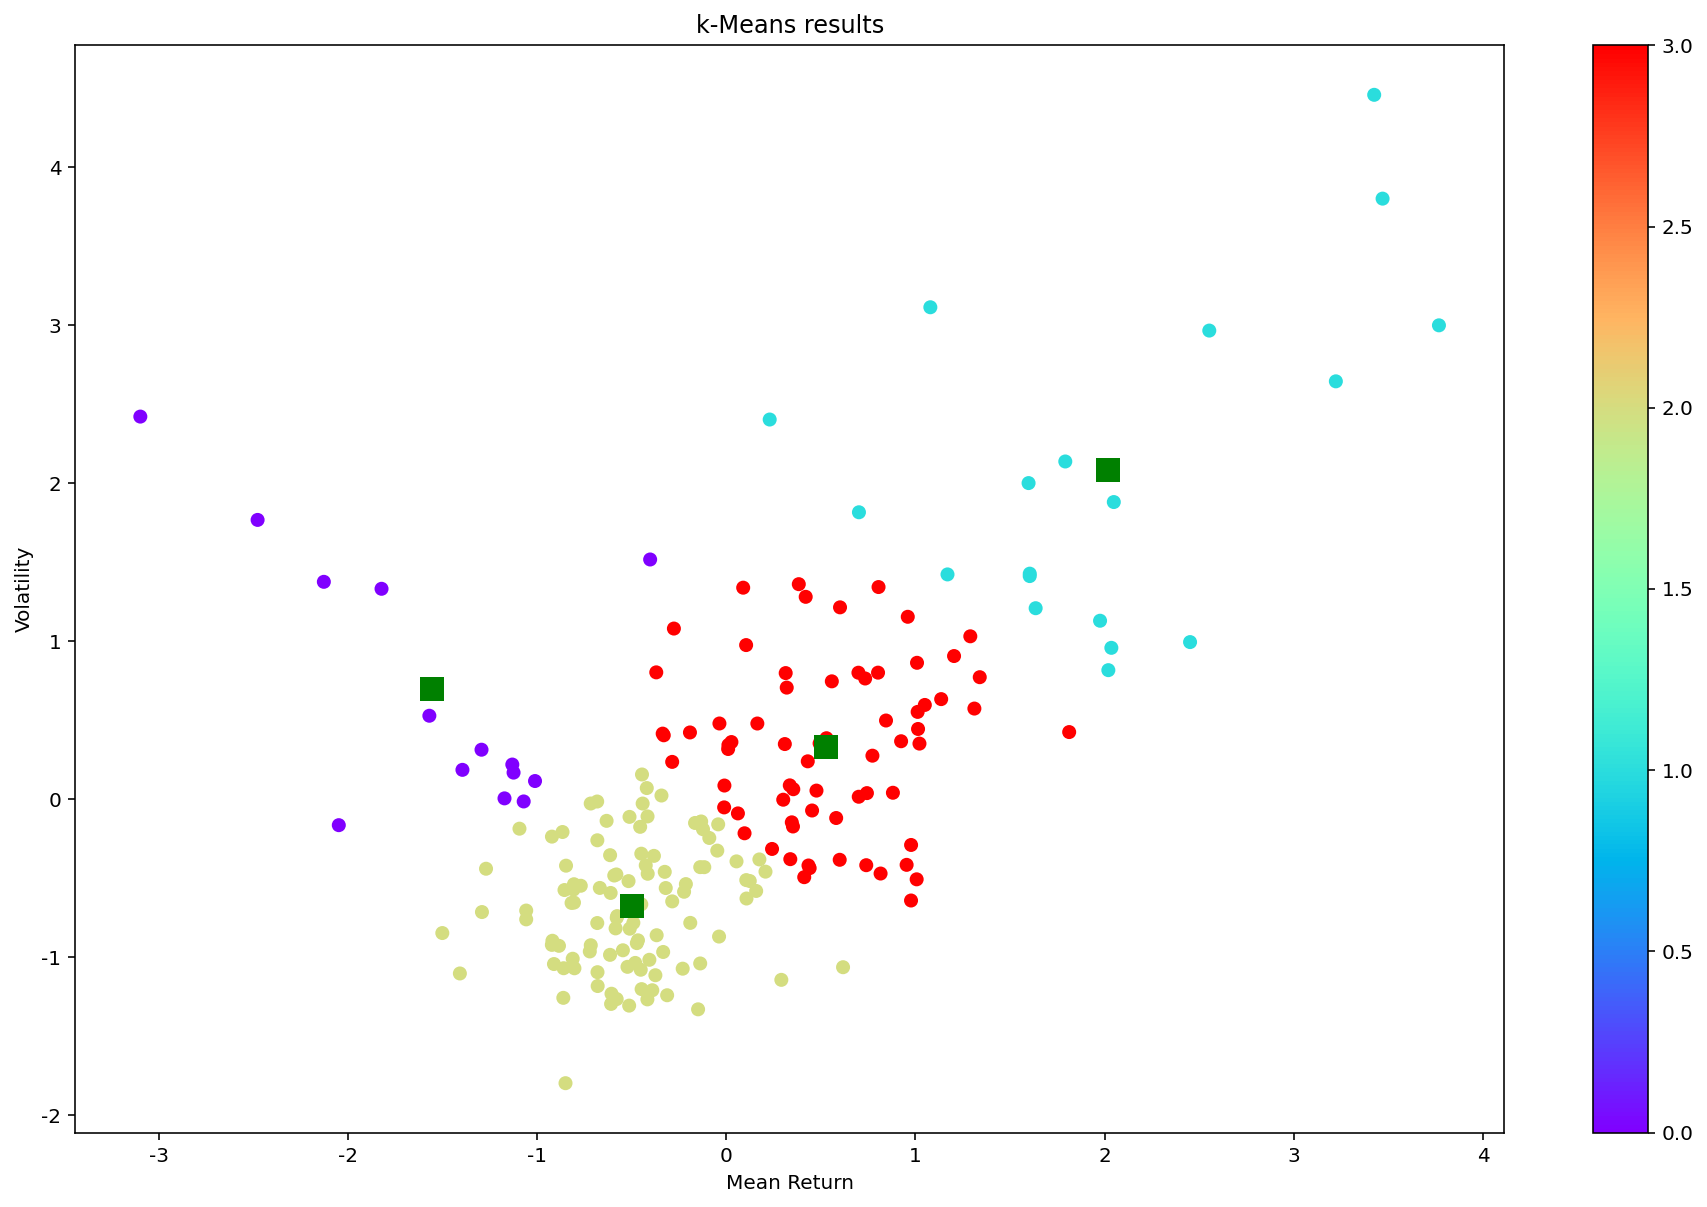

In [123]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

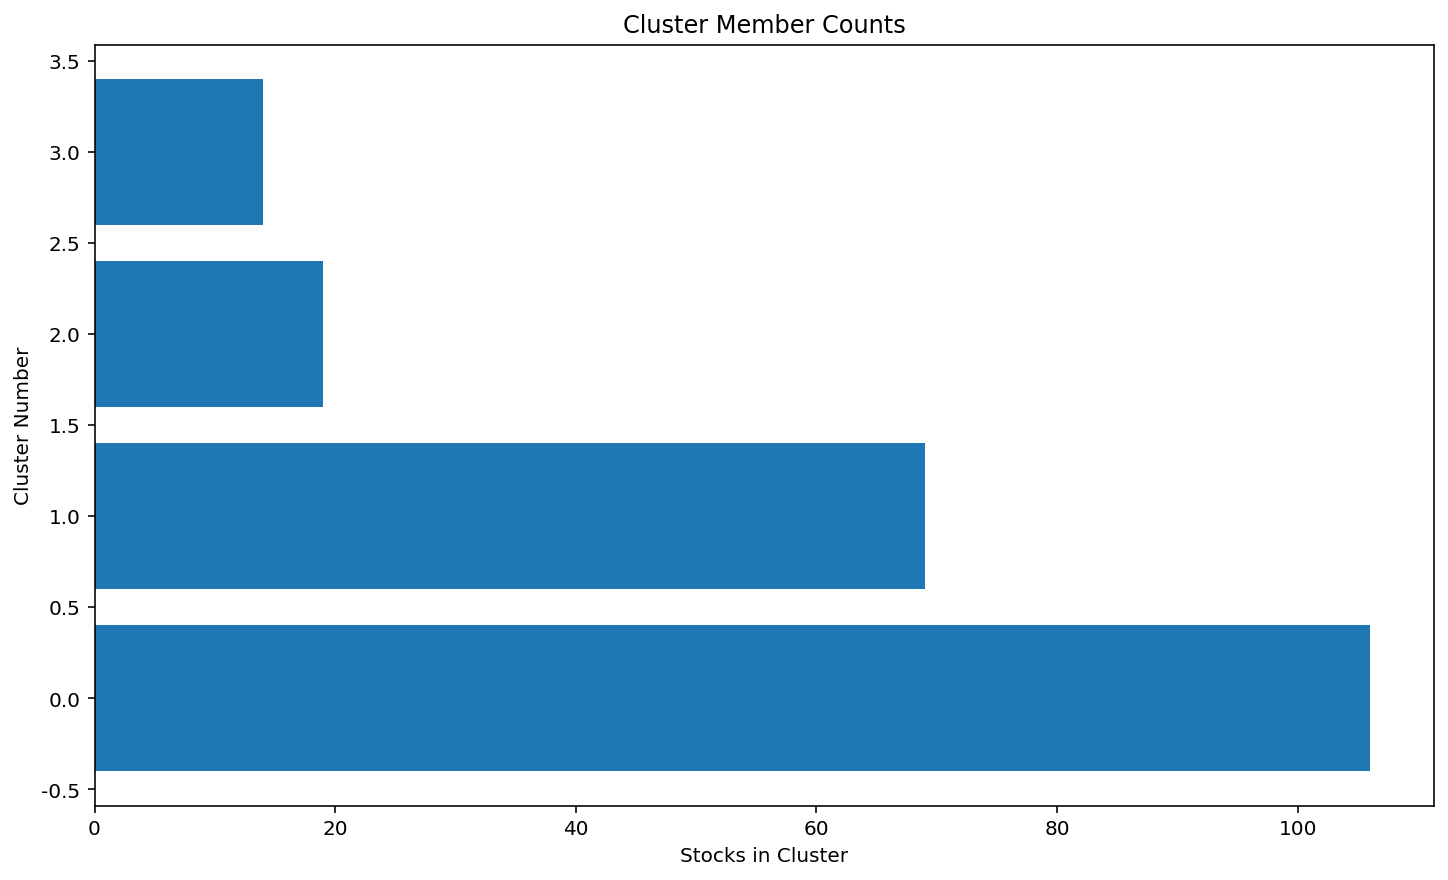

In [124]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series.value_counts())), # cluster labels, y axis
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

### 계층적 군집화

In [125]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

#Calulate linkage
Z= linkage(X, method='ward')
Z[0]

array([1.15000000e+02, 1.82000000e+02, 7.05039797e-03, 2.00000000e+00])

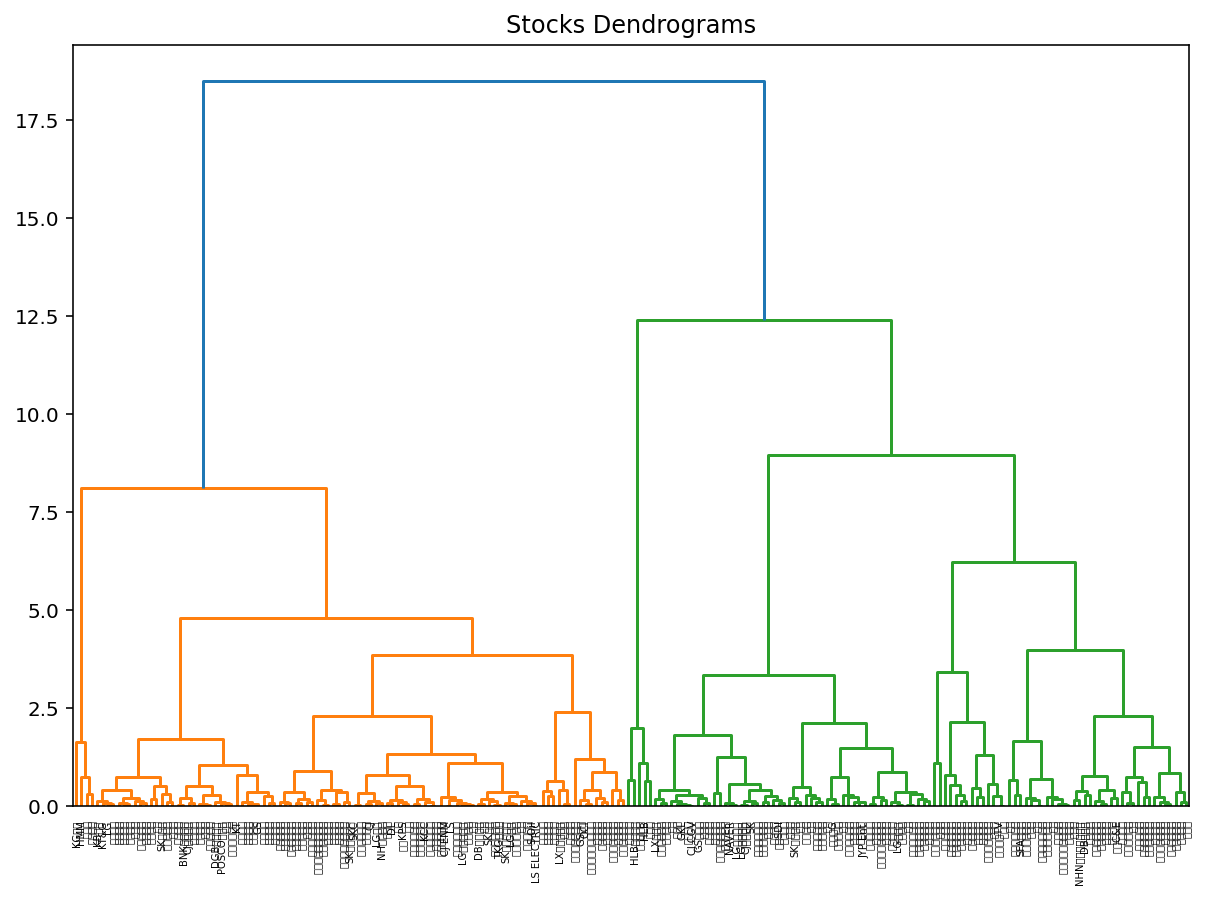

In [126]:
#Plot Dendogram
plt.figure(figsize=(10, 7))
plt.title("Stocks Dendrograms")
dendrogram(Z,labels = X.index)
plt.show()

In [127]:
distance_threshold = 7
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
chosen_clusters['cluster'].unique()

array([4, 2, 5, 1, 3], dtype=int32)

In [128]:
nclust = 5
hc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
clust_labels1 = hc.fit_predict(X)

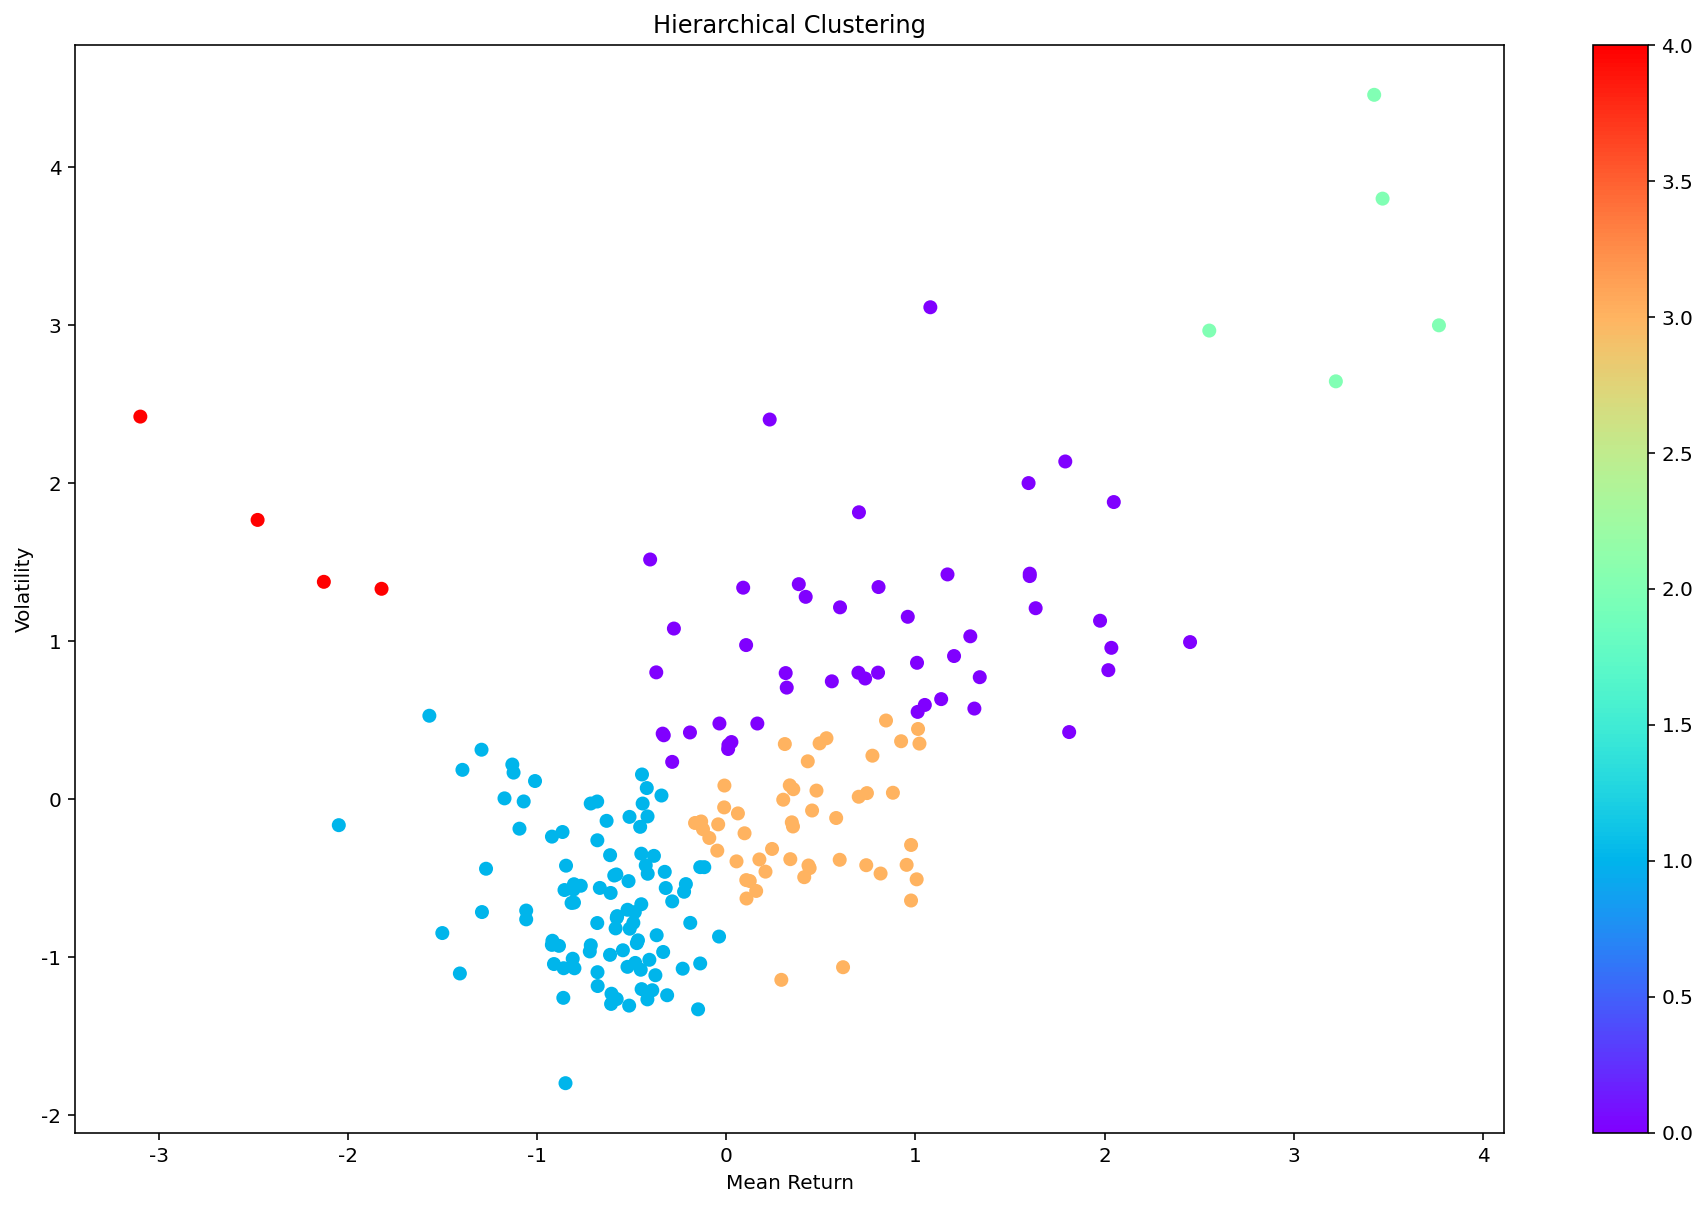

In [129]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

### Affinity Propagation

In [130]:
ap = AffinityPropagation()
ap.fit(X)
clust_labels2 = ap.predict(X)

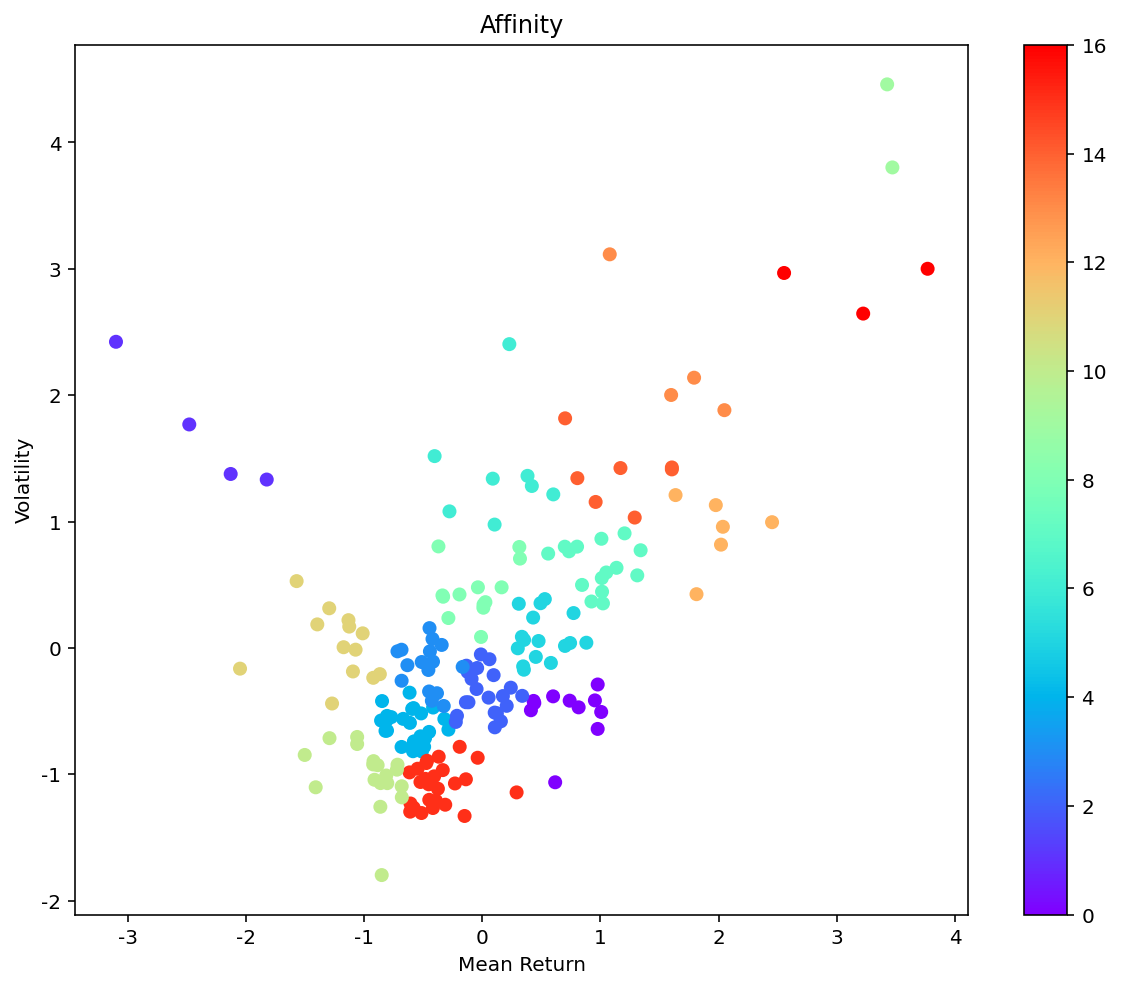

In [131]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

In [132]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

Estimated number of clusters: 17


<Figure size 432x288 with 0 Axes>

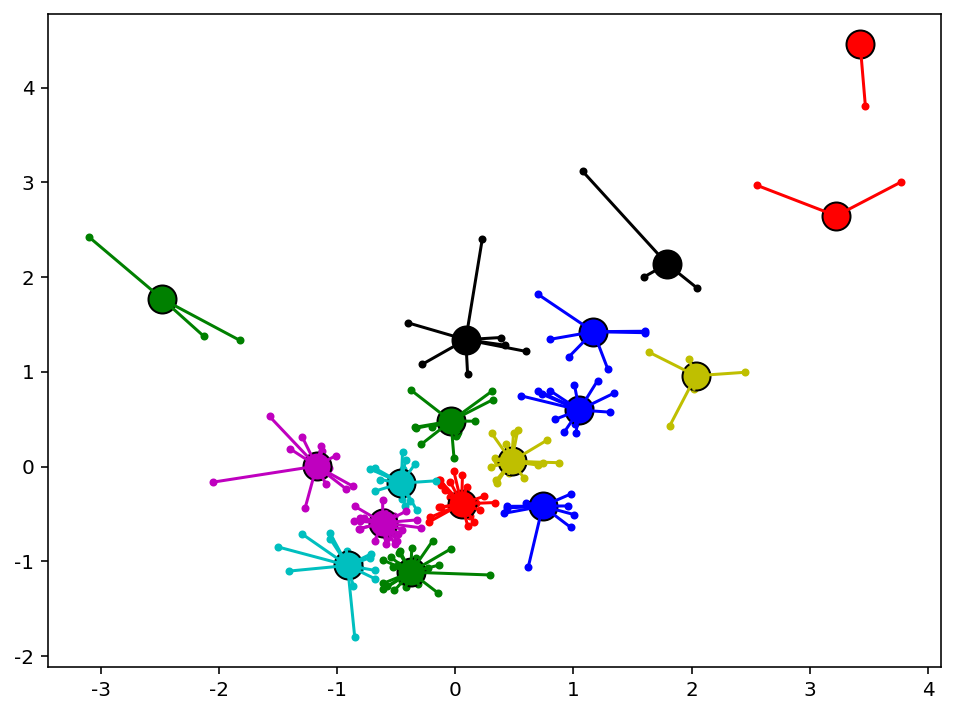

In [133]:
no_clusters = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % no_clusters)

X_temp=np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(8,6))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(no_clusters), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

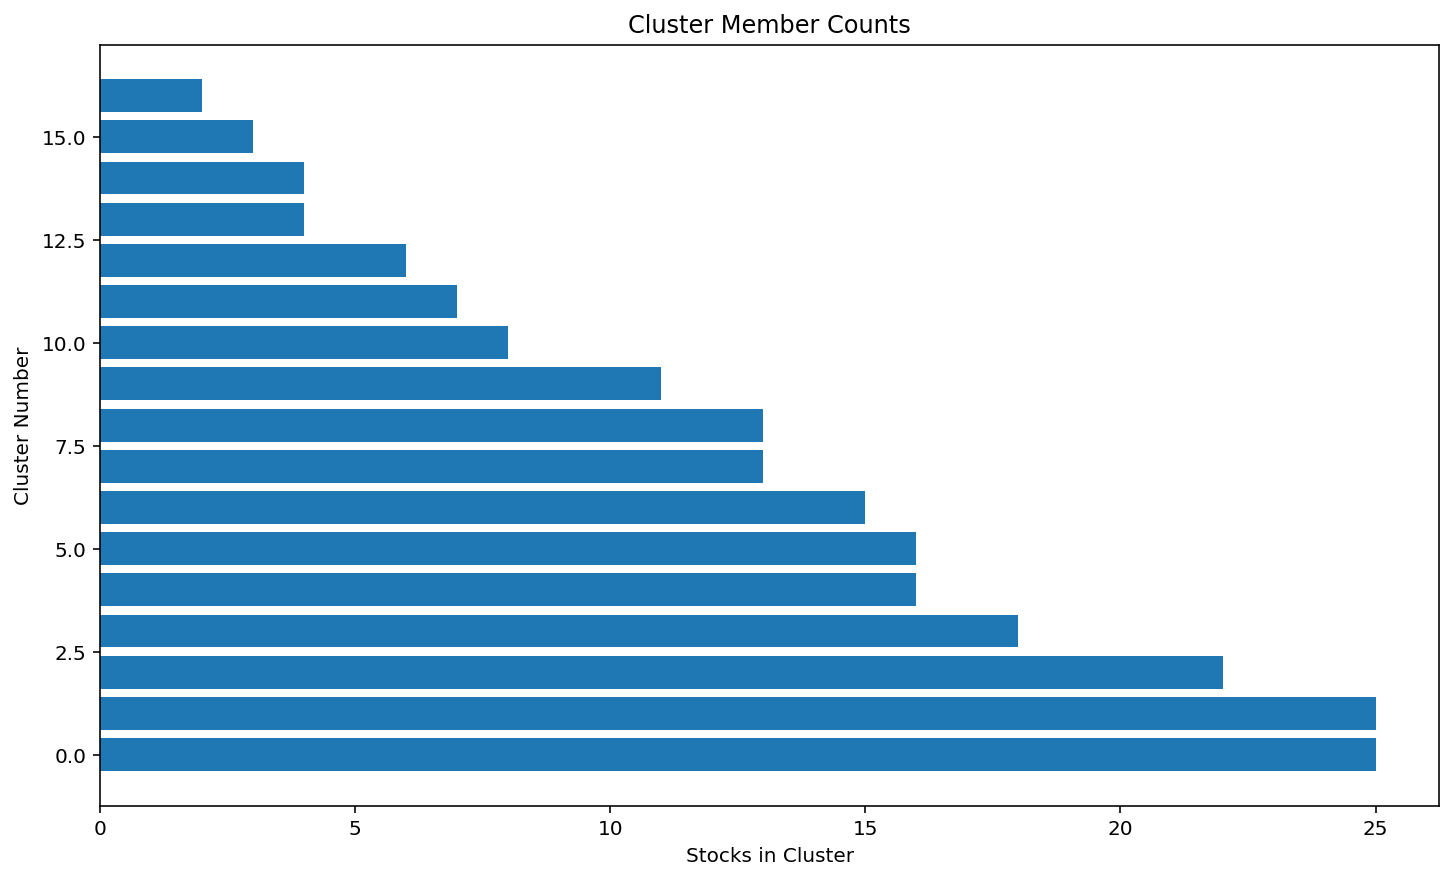

In [134]:
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_all_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_ap = clustered_series_ap[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_ap.value_counts())), # cluster labels, y axis
    clustered_series_ap.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

### GMM

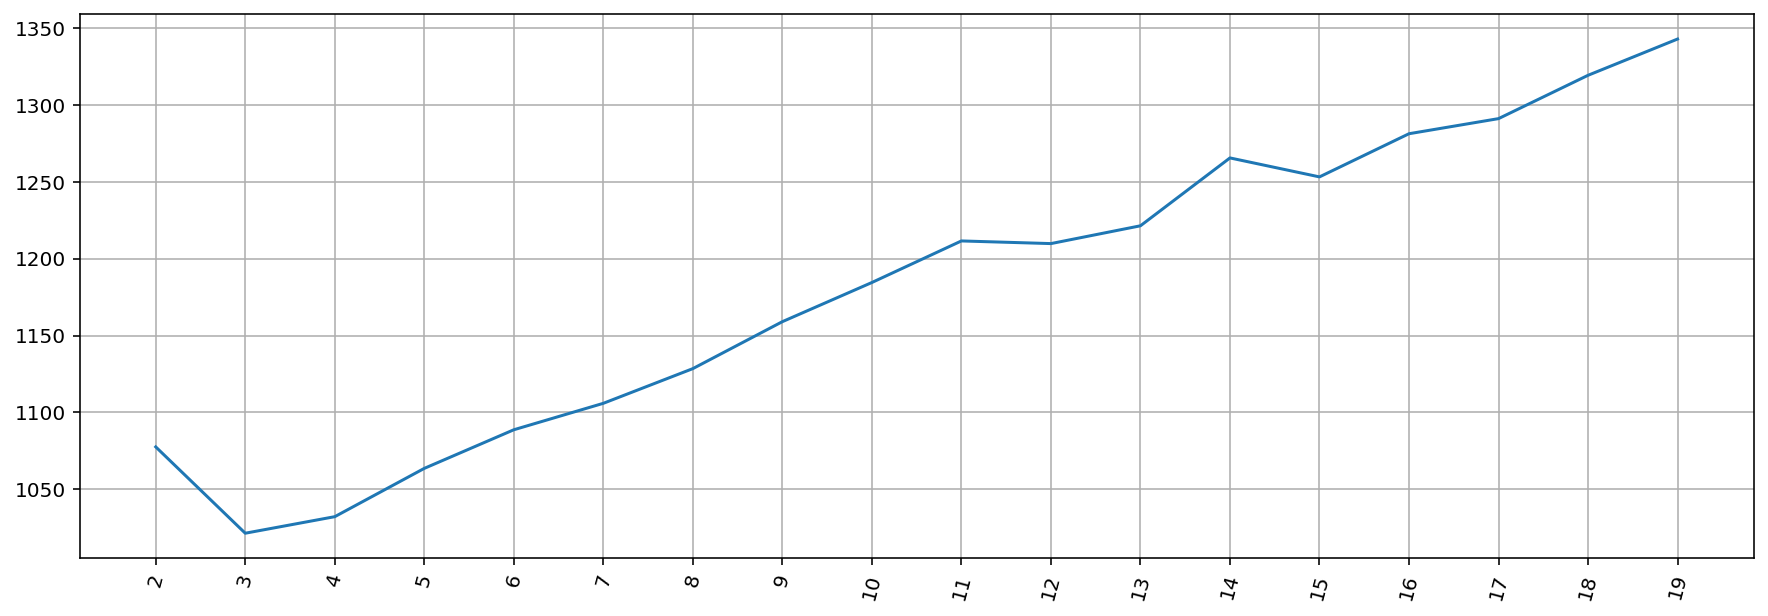

In [135]:
# BIC
BIC = []
max_loop=20
for k in range(2, max_loop):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    BIC.append(gmm.bic(X))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), BIC)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

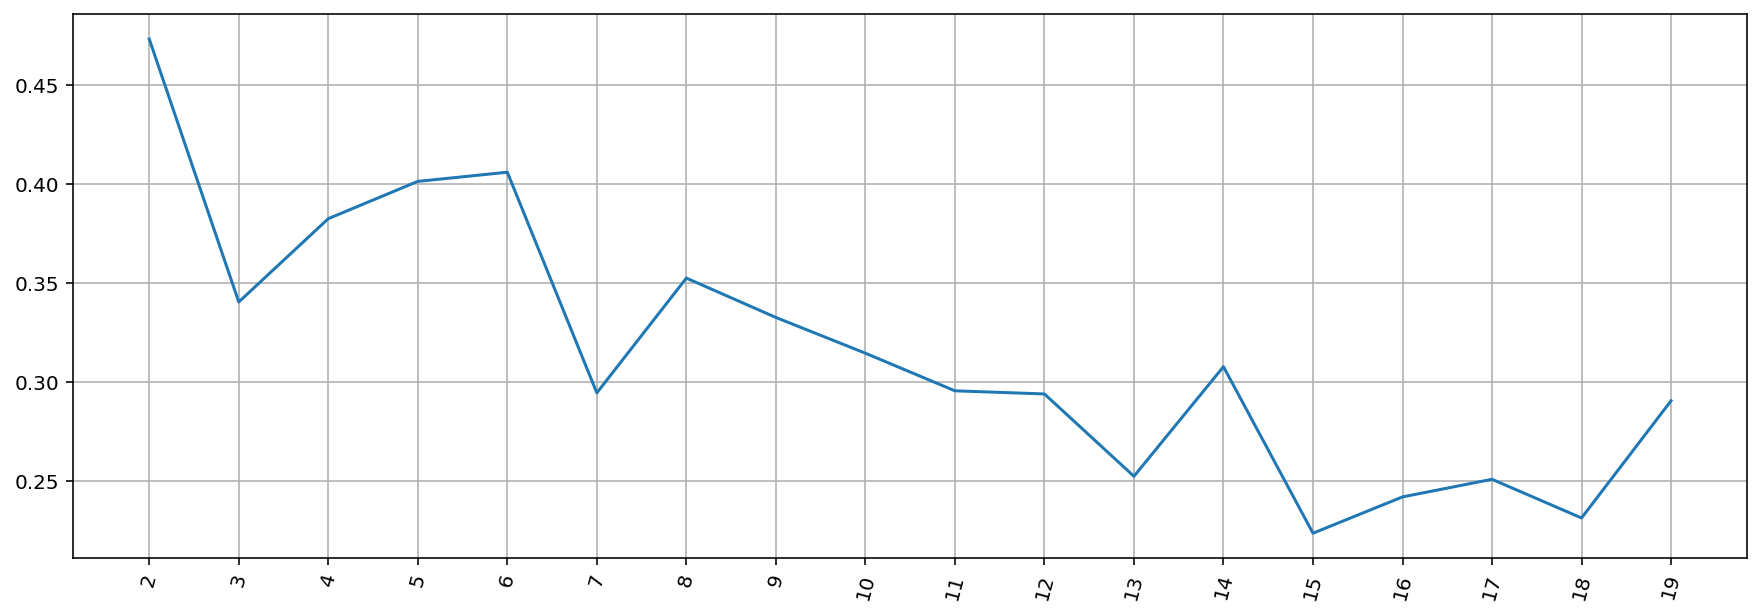

In [136]:
# 실루엣 계수
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
       gmm = GaussianMixture(n_components=k, random_state=42)
       labels = gmm.fit_predict(X)        
       silhouette_score.append(metrics.silhouette_score(X, labels, random_state=42))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

In [137]:
n_components=3

gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X)

GaussianMixture(n_components=3, random_state=42)

In [138]:
target_labels = gmm.predict(X)

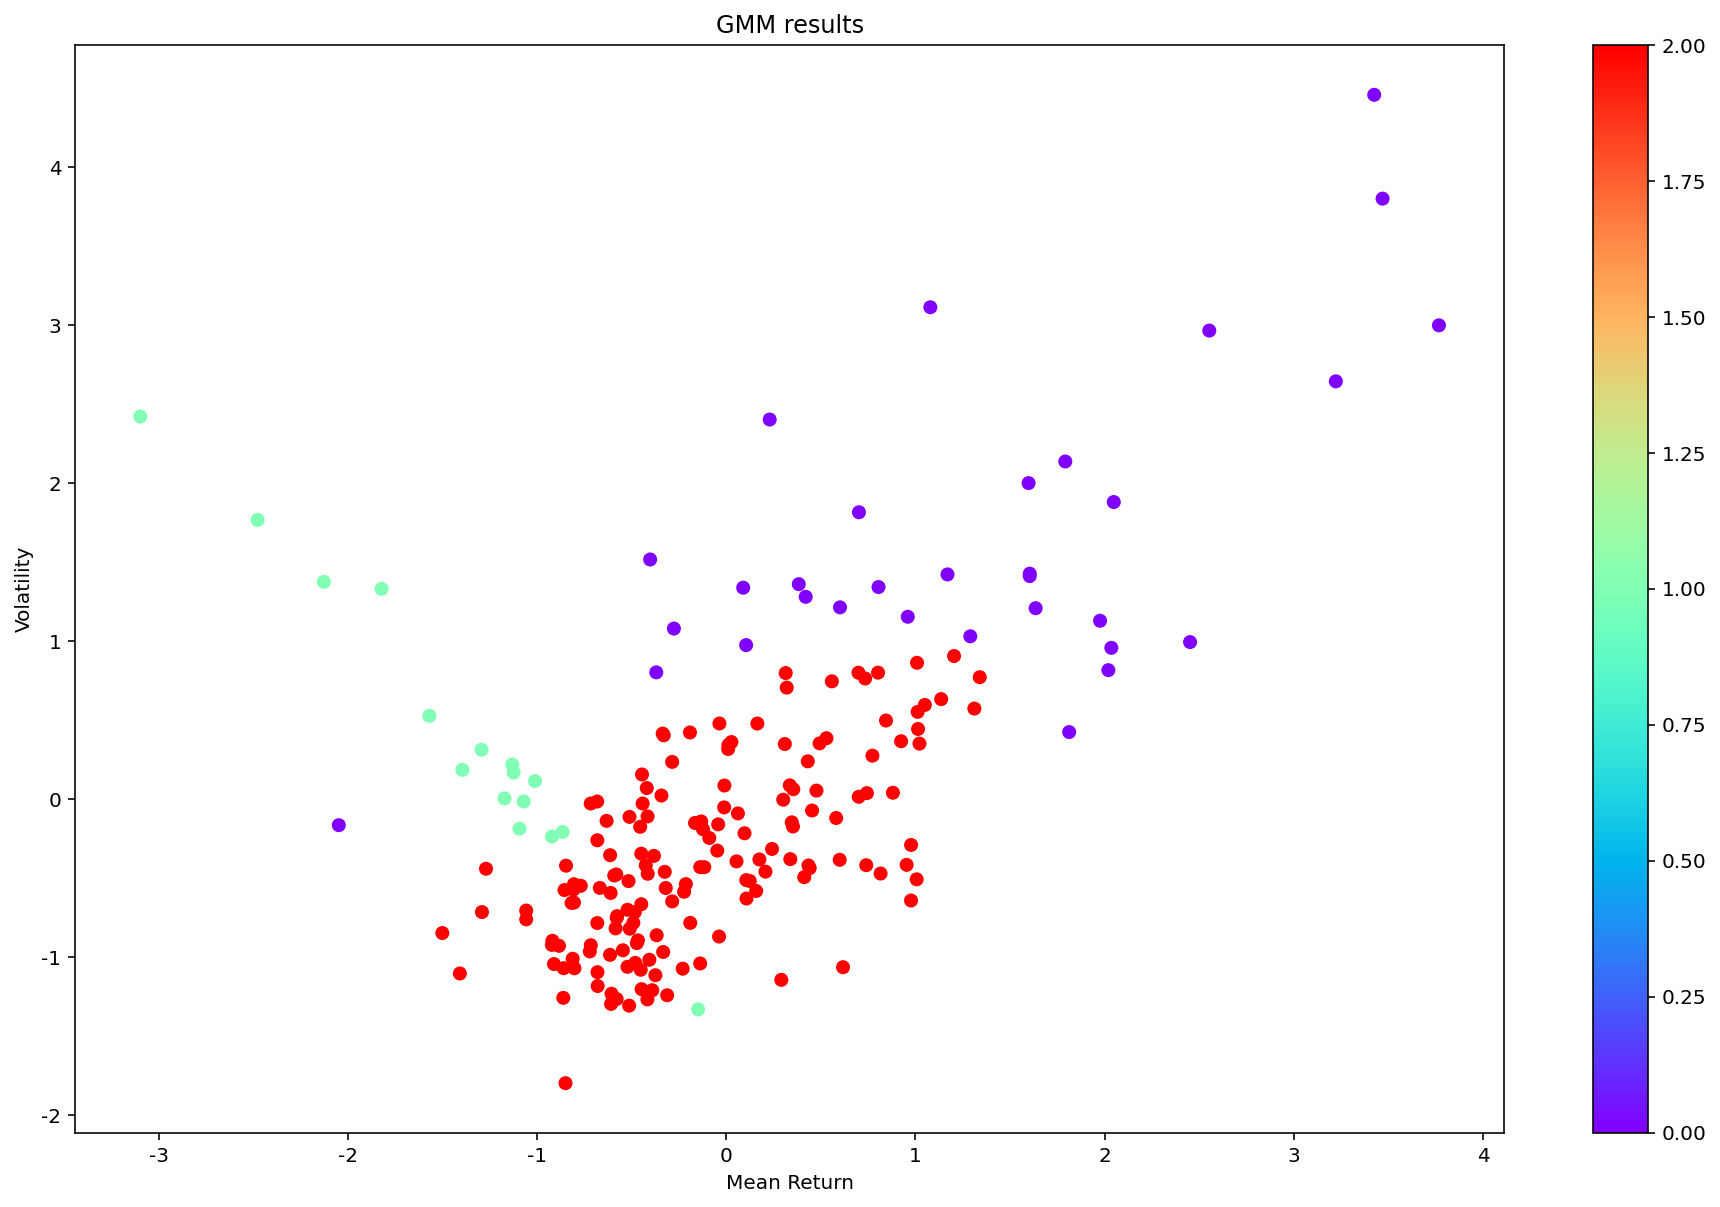

In [139]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = target_labels, cmap ="rainbow", label = X.index)
ax.set_title('GMM results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

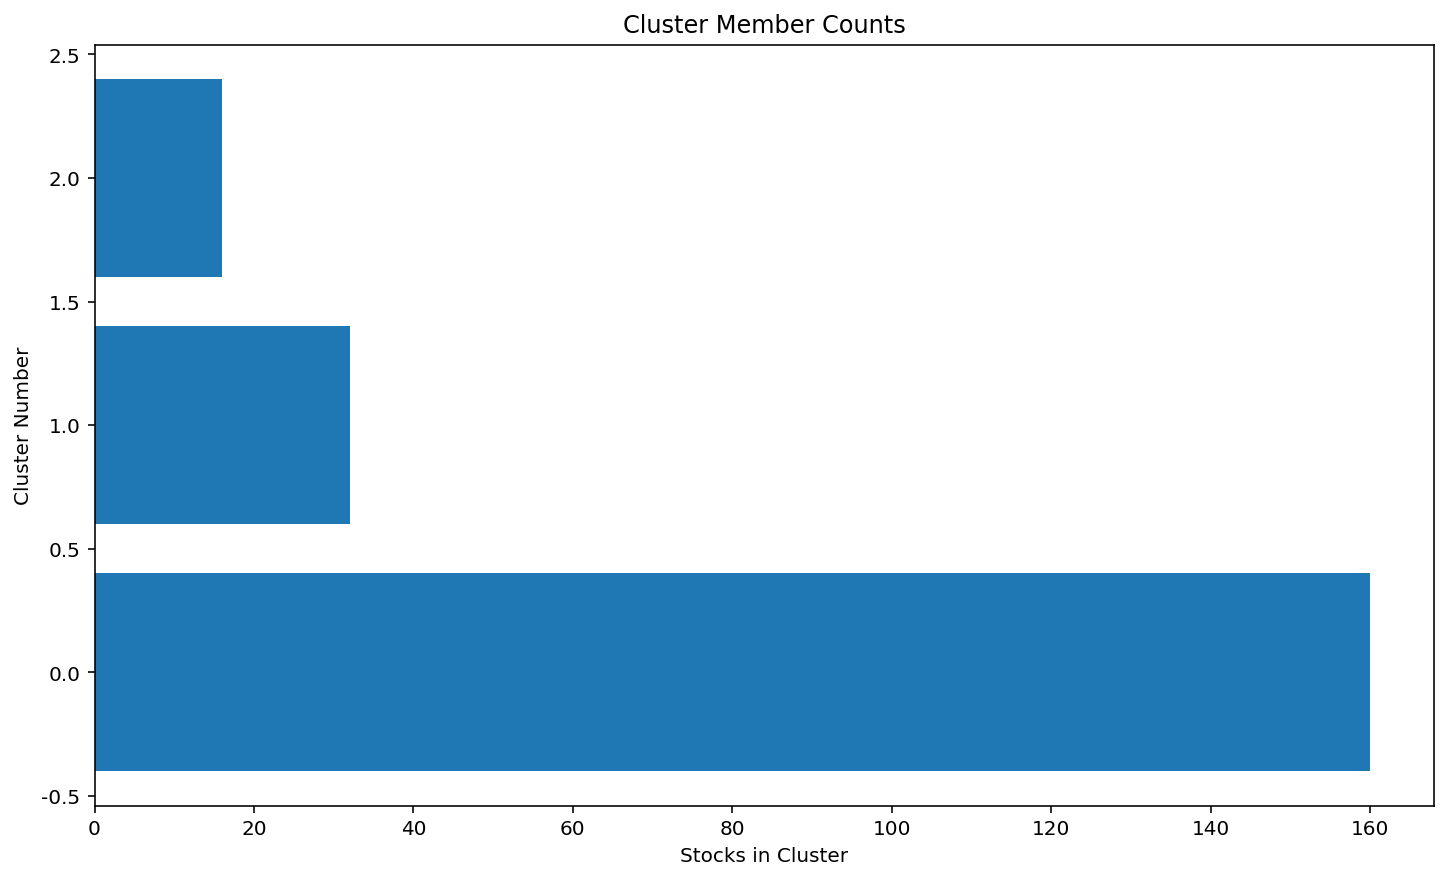

In [140]:
clustered_series = pd.Series(index=X.index, data=target_labels.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=target_labels.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series.value_counts())), # cluster labels, y axis
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

### DBSCAN

In [141]:
num_clusters = []
num_noise_points = []
for i in range (1,21):
  model= DBSCAN(eps=i * 0.05, min_samples=3)
  model.fit(X)
  labels = model.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  num_clusters.append(n_clusters_)
  num_noise_points.append(n_noise_)

eps = pd.DataFrame({'num_clusters': num_clusters, 'num_noise_points': num_noise_points}).set_index(np.array(range(1,21)) * 0.05)
eps.index.names = ["eps"]
eps.head()

num_clusters  num_noise_points
eps                                 
0.05             5               191
0.10            20               116
0.15            10                67
0.20             6                40
0.25             4                30

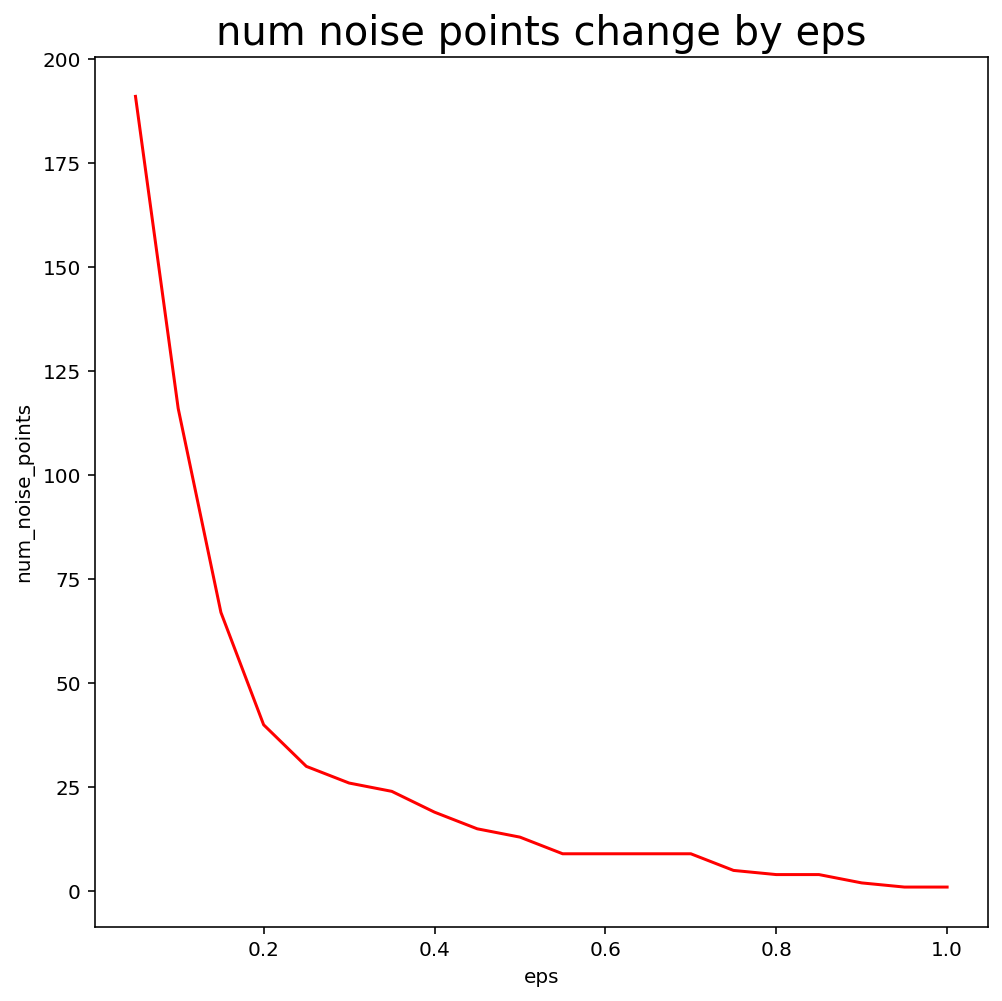

In [142]:
plt.figure(figsize=(8,8))
plt.plot(eps.num_noise_points, c='r')
plt.title('num noise points change by eps', fontsize=20)
plt.xlabel('eps', fontsize=10)
plt.ylabel('num_noise_points', fontsize=10)
plt.show()

In [143]:
eps=0.2
min_samples=3
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
target_labels = dbscan.fit_predict(X)

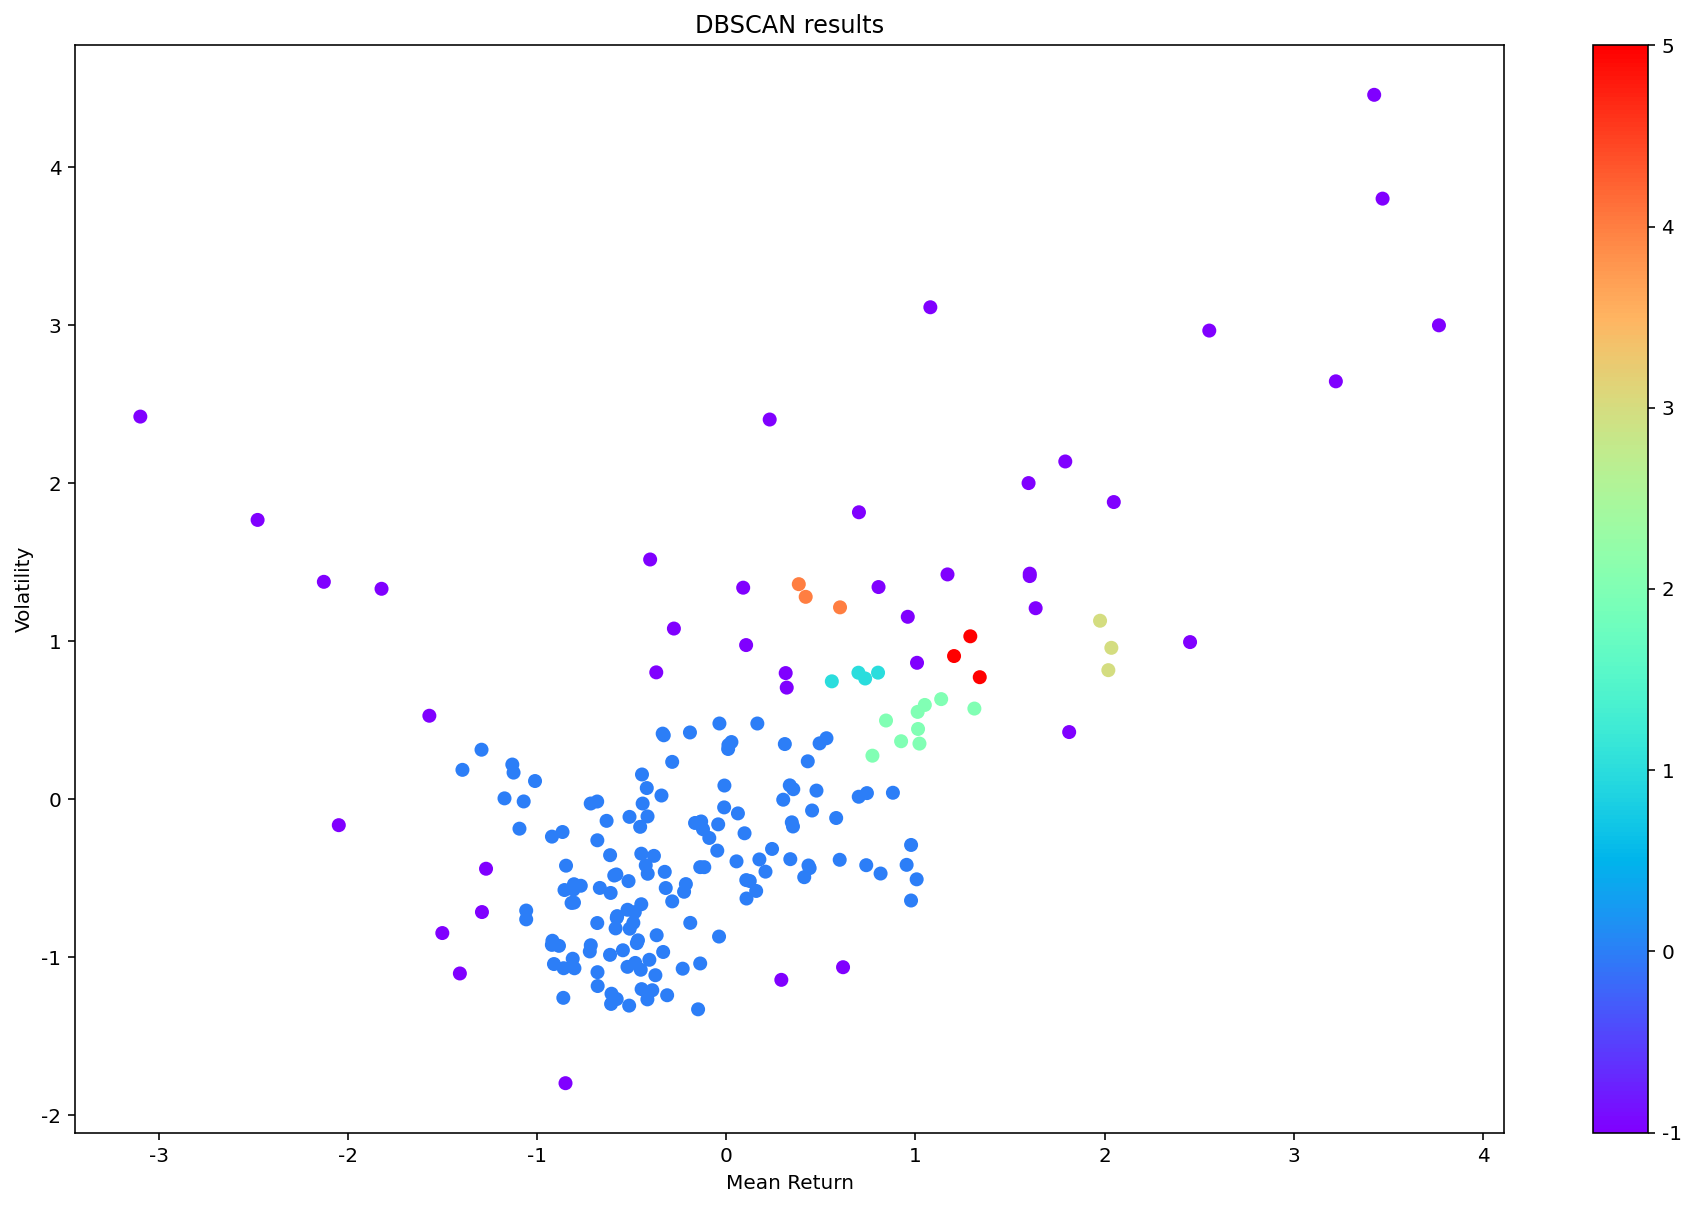

In [144]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = target_labels, cmap ="rainbow", label = X.index)
ax.set_title('DBSCAN results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

### 군집화 평가

In [145]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))
print('gmm', metrics.silhouette_score(X, gmm.fit_predict(X), metric='euclidean'))

km 0.4265169099355726
hc 0.37066322529910767
ap 0.35057075343092314
gmm 0.34048338130327765


## Finding pair

In [146]:
# all stock with its cluster label (including -1)
clustered_series = pd.Series(index=X.index, data=k_means.fit_predict(X).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]

In [147]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 4
Pairs to evaluate: 16346


In [148]:
def find_cointegrated_pairs(data, significance=0.01):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [149]:
from statsmodels.tsa.stattools import coint
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index   
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        train[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


In [150]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [151]:
print ("Number of pairs found : %d" % len(pairs))
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))

Number of pairs found : 171
In those pairs, there are 120 unique tickers.


In [152]:
print(len(pairs))
print(pairs)

171
[('삼성전자', '에스에프에이'), ('현대차', '포스코인터내셔널'), ('삼성SDI', '동양생명'), ('LG화학', 'S-Oil'), ('현대모비스', 'SK'), ('현대모비스', 'LG'), ('현대모비스', 'SK텔레콤'), ('현대모비스', 'KT&G'), ('현대모비스', 'KT'), ('현대모비스', '삼성화재'), ('현대모비스', '고려아연'), ('현대모비스', '현대글로비스'), ('현대모비스', '기업은행'), ('현대모비스', '한국조선해양'), ('현대모비스', 'LG유플러스'), ('현대모비스', '유한양행'), ('현대모비스', 'DB손해보험'), ('현대모비스', '현대제철'), ('현대모비스', '메리츠화재'), ('현대모비스', '한국금융지주'), ('현대모비스', 'NH투자증권'), ('현대모비스', '메리츠금융지주'), ('현대모비스', '롯데쇼핑'), ('현대모비스', '에스원'), ('현대모비스', 'CJ대한통운'), ('현대모비스', '대우건설'), ('현대모비스', '포스코인터내셔널'), ('현대모비스', '한화에어로스페이스'), ('현대모비스', '키움증권'), ('현대모비스', 'LS'), ('현대모비스', '현대위아'), ('현대모비스', '현대백화점'), ('현대모비스', '에스에프에이'), ('현대모비스', 'DGB금융지주'), ('현대모비스', '유니드'), ('현대모비스', '서울반도체'), ('현대모비스', '대신증권'), ('현대모비스', '세방전지'), ('현대모비스', '한섬'), ('POSCO홀딩스', 'LS'), ('신한지주', '삼성증권'), ('신한지주', '한화에어로스페이스'), ('신한지주', '하이트진로'), ('신한지주', '에스엘'), ('신한지주', '현대백화점'), ('신한지주', 'SK가스'), ('신한지주', '세방전지'), ('SK', '메리츠금융지주'), ('한국전력', '강원랜드'), ('LG', '메리츠화재'), ('LG', '대신증권'), ('KT&G

## Perform EDA for Selected pair

### Choose one pair

In [153]:
asset1 = 'LG화학'
asset2 = 'S-Oil'

In [154]:
pair1 = pd.DataFrame()
pair1[asset1] = train[asset1]
pair1[asset2] = train[asset2]

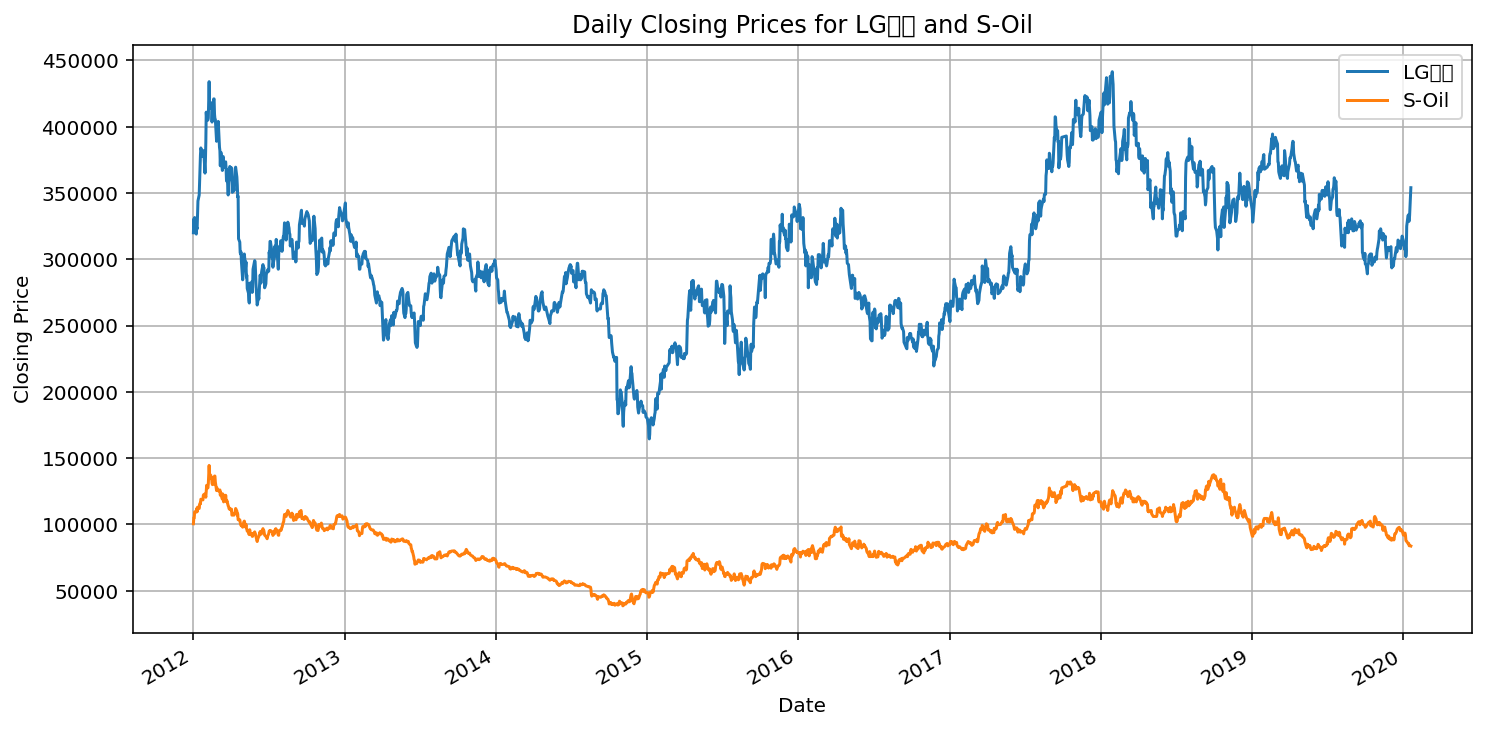

In [155]:
# 두 자산의 움직임을 시각화
ax = pair1[[asset1, asset2]].plot(figsize=(12, 6))
ax.set_title('Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True)

### Calculate spread and ratio

In [156]:
# run OLS regression
model=sm.OLS(pair1['S-Oil'], pair1.LG화학).fit()

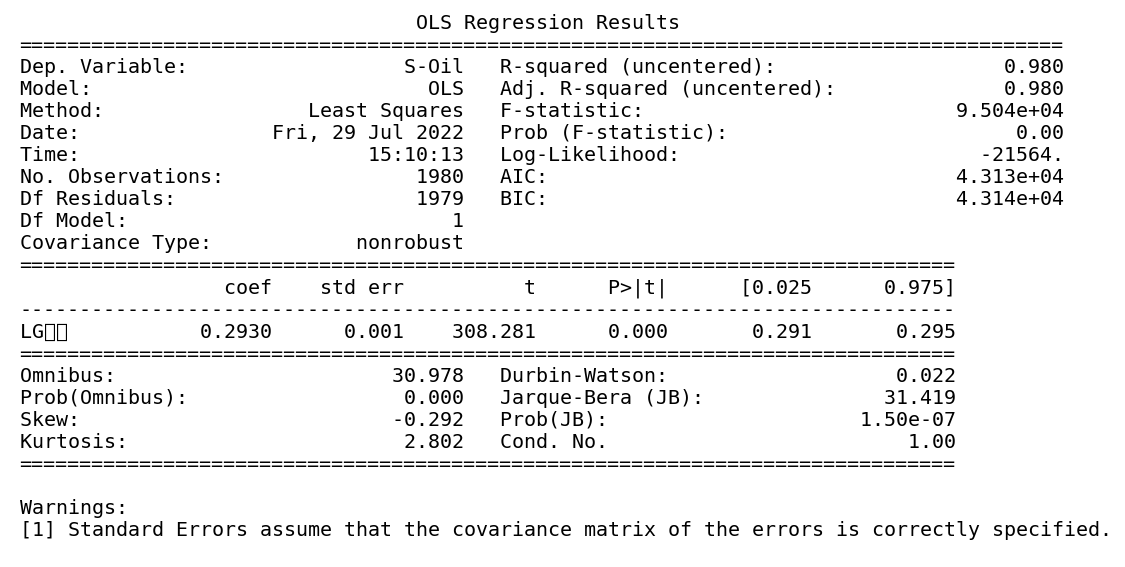

In [157]:
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

In [158]:
# calculate spread
spread = pair1['S-Oil'] - model.params[0] * pair1.LG화학

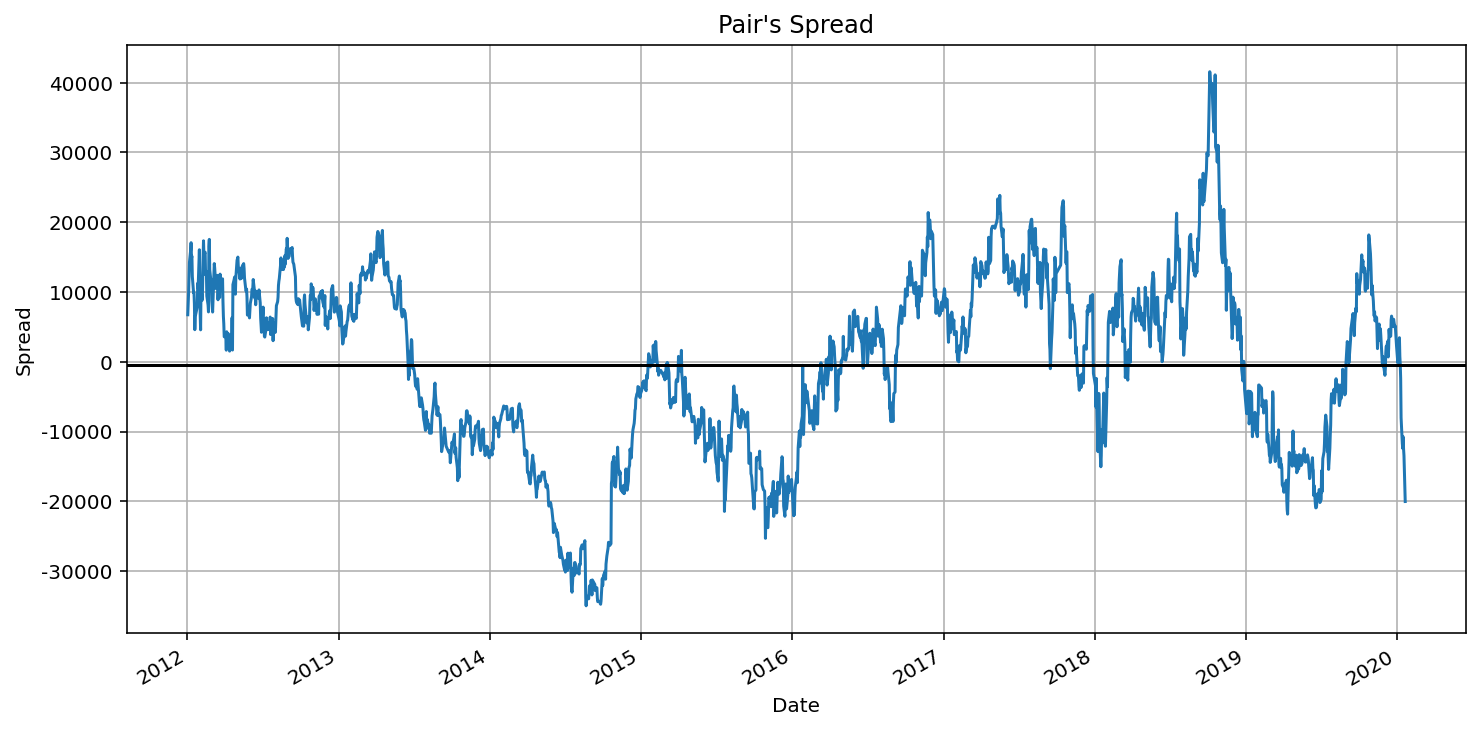

In [159]:
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.axhline(spread.mean(), color='black')
ax.set_ylabel("Spread")
ax.grid(True)

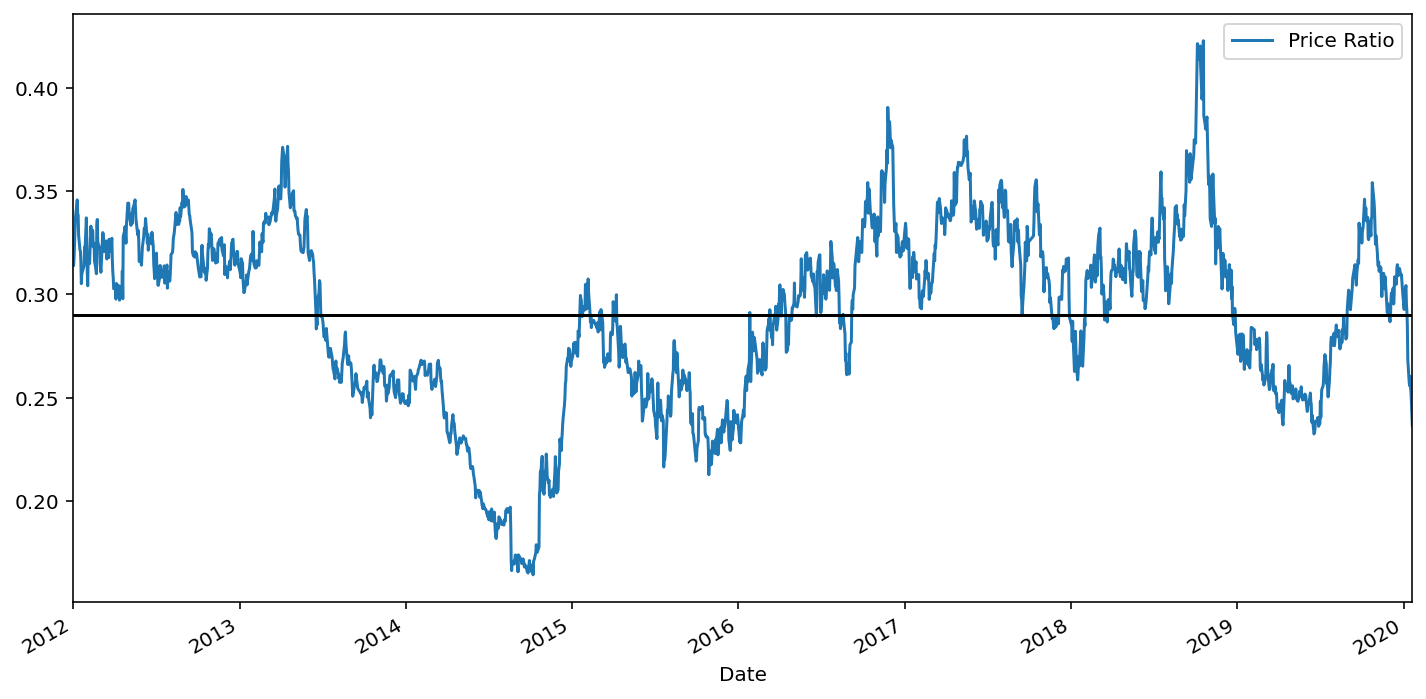

In [160]:
# Price ratio를 그리기
ratio = pair1['S-Oil'] / pair1.LG화학
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2012-01-01', '2020-01-20')
plt.legend(['Price Ratio'])

In [161]:
# ADF test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

Critical Value =  -3.168243361667342


## Generate Trading Signals using z-score

In [162]:
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=0,
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [163]:
# calculate z-score
def zscore(series):
    return (series-series.mean()) / np.std(series)

In [164]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['LG화학'] = train['LG화학'] 
signals['S-Oil'] = train['S-Oil']

LG화학_state_means, _ = kf.filter(signals['LG화학'])
S_Oil_state_means, _ = kf.filter(signals['S-Oil'])
ratios = LG화학_state_means / S_Oil_state_means

In [165]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = (np.mean(signals['z']) + np.std(signals['z']))
signals['z lower limit'] = (np.mean(signals['z']) - np.std(signals['z']))

In [166]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [167]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

In [168]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

LG화학     S-Oil         z  z upper limit  z lower limit  \
Date                                                                     
2012-01-02  320000.0  100500.0 -0.573780            1.0           -1.0   
2012-01-03  330500.0  105000.0 -0.604200            1.0           -1.0   
2012-01-04  324500.0  105000.0 -0.646161            1.0           -1.0   
2020-01-16  329000.0   83900.0 -0.024511            1.0           -1.0   
2020-01-17  333000.0   84100.0  0.038612            1.0           -1.0   
2020-01-20  354000.0   83700.0  0.135279            1.0           -1.0   

            signals1  positions1  signals2  positions2  
Date                                                    
2012-01-02         0         NaN         0         NaN  
2012-01-03         0         0.0         0         0.0  
2012-01-04         0         0.0         0         0.0  
2020-01-16         0         0.0         0         0.0  
2020-01-17         0         0.0         0         0.0  
2020-01-20         0         0.0         0         0.0

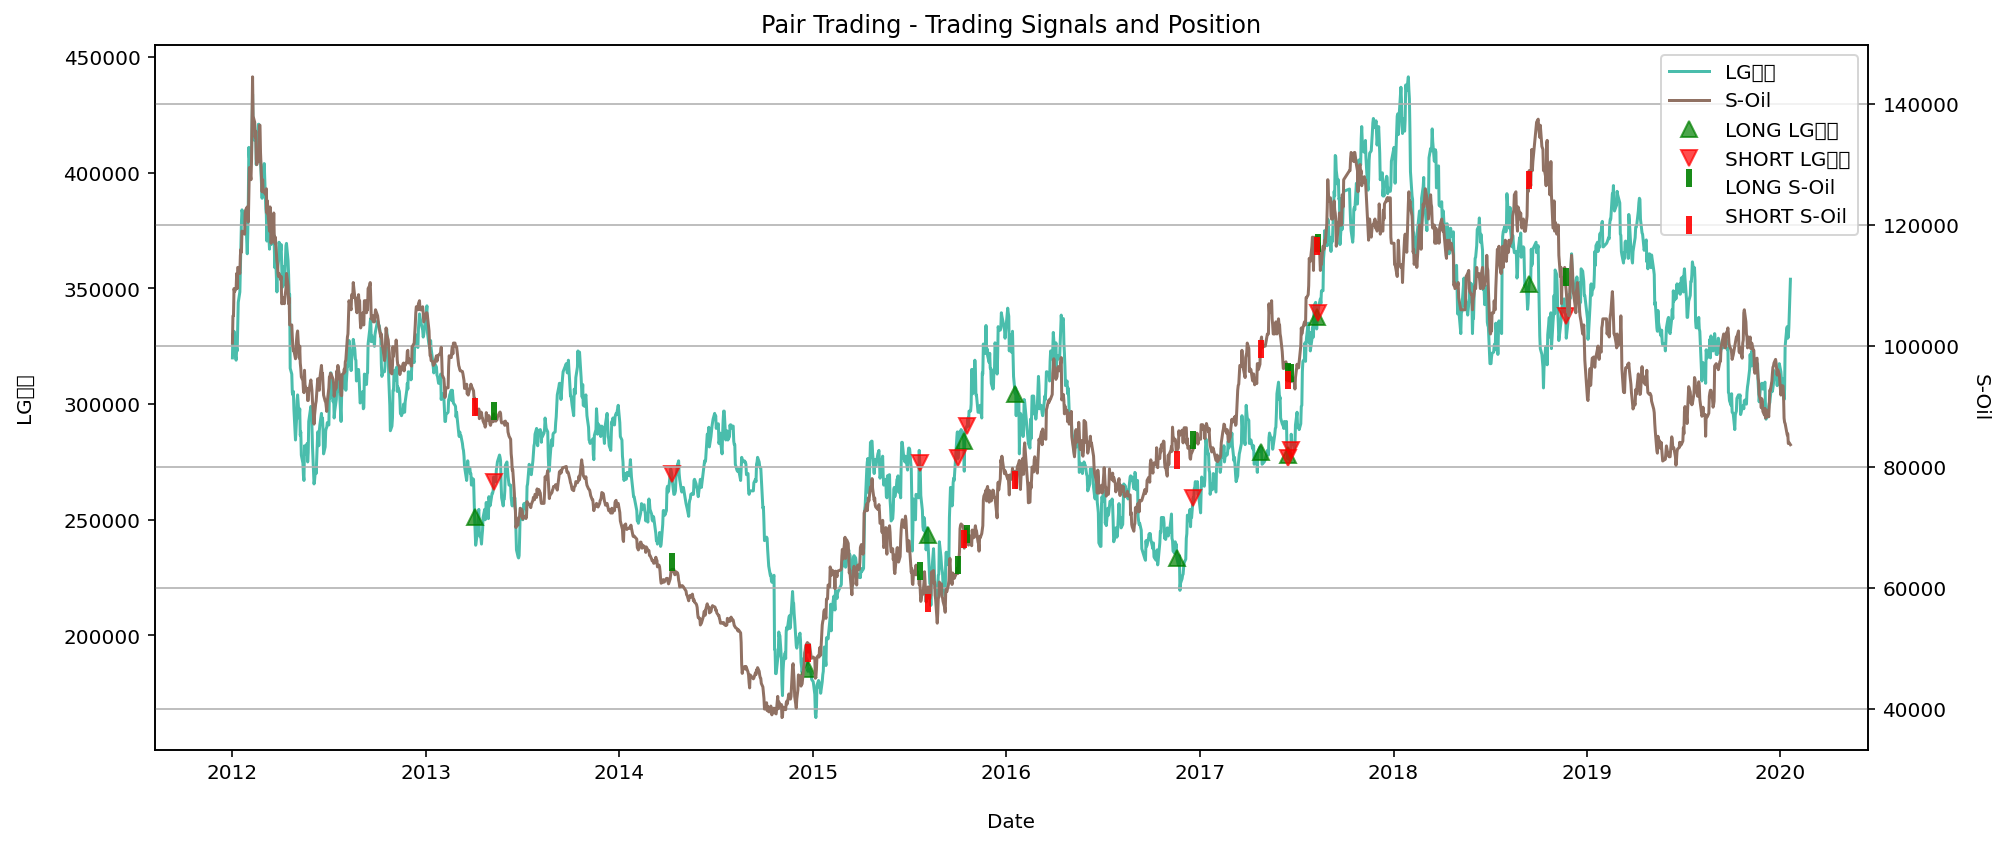

In [169]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['LG화학'], c='#4abdac')
l2, = bx2.plot(signals['S-Oil'], c='#907163')

u1, = bx.plot(signals['LG화학'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['LG화학'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['S-Oil'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['S-Oil'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format("LG화학"),
           'SHORT {}'.format("LG화학"),
           'LONG {}'.format("S-Oil"),
           'SHORT {}'.format("S-Oil")], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()

## Portfolio Profit and Loss Calculation

In [170]:
# initial capital to calculate the actual pnl
initial_capital = 1e8 / 2

# shares to buy for each position
positions1 = initial_capital// max(signals['LG화학'])
positions2 = initial_capital// max(signals['S-Oil'])

In [171]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['LG화학'] = signals['LG화학']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['LG화학'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['LG화학'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [172]:
portfolio['S-Oil'] = signals['S-Oil']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['S-Oil'] * positions1
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['S-Oil'] * positions1).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [173]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

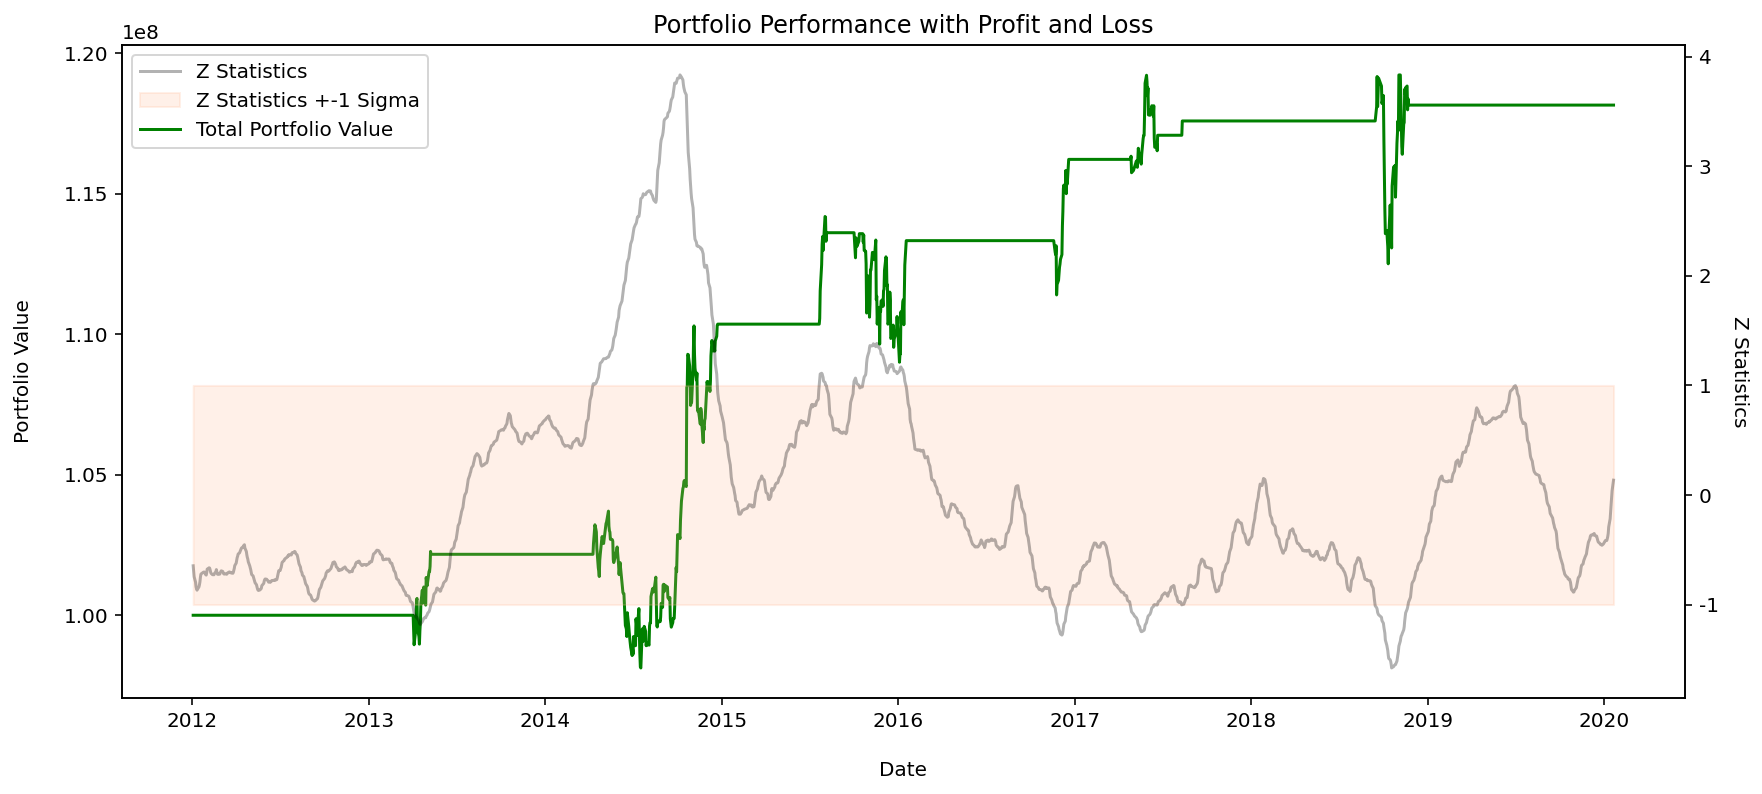

In [174]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left')

In [175]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)

Number of days =  2938


In [176]:
YEAR_DAYS = 252
returns = (final_portfolio/(initial_capital*2)) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 1.442%


### Portfolio(All pairs)

In [177]:
def trade(S1, S2, bound, initial_capital, train_set=True):

    if train_set:
        signals = pd.DataFrame()
        signals[S1] = train[S1] 
        signals[S2] = train[S2]
    else:
        signals = pd.DataFrame()
        signals[S1] = test[S1]
        signals[S2] = test[S2]
        
    ratios = kf.filter(signals[S1])[0] / kf.filter(signals[S2])[0]
    signals['z'] = zscore(ratios)
    signals['z upper limit'] = (np.mean(signals['z']) + np.std(signals['z'])) * abs(bound)
    signals['z lower limit'] = (np.mean(signals['z']) - np.std(signals['z'])) * abs(bound)
    
    signals['signals1'] = 0
    signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)
    
    signals['positions1'] = signals['signals1'].diff()
    signals['signals2'] = -signals['signals1']
    signals['positions2'] = signals['signals2'].diff()
    
    # initial capital to calculate the actual pnl
    initial_capital = initial_capital/2

    # shares to buy for each position
    positions1 = initial_capital// max(signals[S1])
    positions2 = initial_capital// max(signals[S2])
    
    # since there are two assets, we calculate each asset Pnl separately 
    # and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = signals[S1]
    portfolio['holdings1'] = signals['positions1'].cumsum() * signals[S1] * positions1
    portfolio['cash1'] = initial_capital - (signals['positions1'] * signals[S1] * positions1).cumsum()
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = signals['positions1']
    
    portfolio[S2] = signals[S2]
    portfolio['holdings2'] = signals['positions2'].cumsum() * signals[S2] * positions1
    portfolio['cash2'] = initial_capital - (signals['positions2'] * signals[S2] * positions1).cumsum()
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = signals['positions2']
    
    # total pnl and z-score
    portfolio['z'] = signals['z']
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = signals['z upper limit']
    portfolio['z lower limit'] = signals['z lower limit']
    portfolio = portfolio.dropna()
    
    total_asset = portfolio['total asset']
    
    return total_asset

In [178]:
def pair_portfolio_return(pair_list, bound, initial_capital, train_set=True):
    capital = initial_capital/len(pair_list)
    if train_set:
        total_return = []
        for pair in pair_list:
            S1, S2 = pair[0], pair[1]
            pair_return = trade(S1, S2, bound, capital, train_set=True)
            total_return.append(pair_return)
        total_return = pd.DataFrame(np.array(total_return).squeeze().T).sum(axis=1)
        total_return.index = train.index[2:]
    else:
        total_return = []
        for pair in pair_list:
            S1, S2 = pair[0],pair[1]
            pair_return = trade(S1, S2, bound, capital, train_set=False)
            total_return.append(pair_return)
        total_return = pd.DataFrame(np.array(total_return).squeeze().T).sum(axis=1)
        total_return.index = test.index[2:]
    return total_return

In [179]:
total_df = pair_portfolio_return(pairs, 1, 1e10)

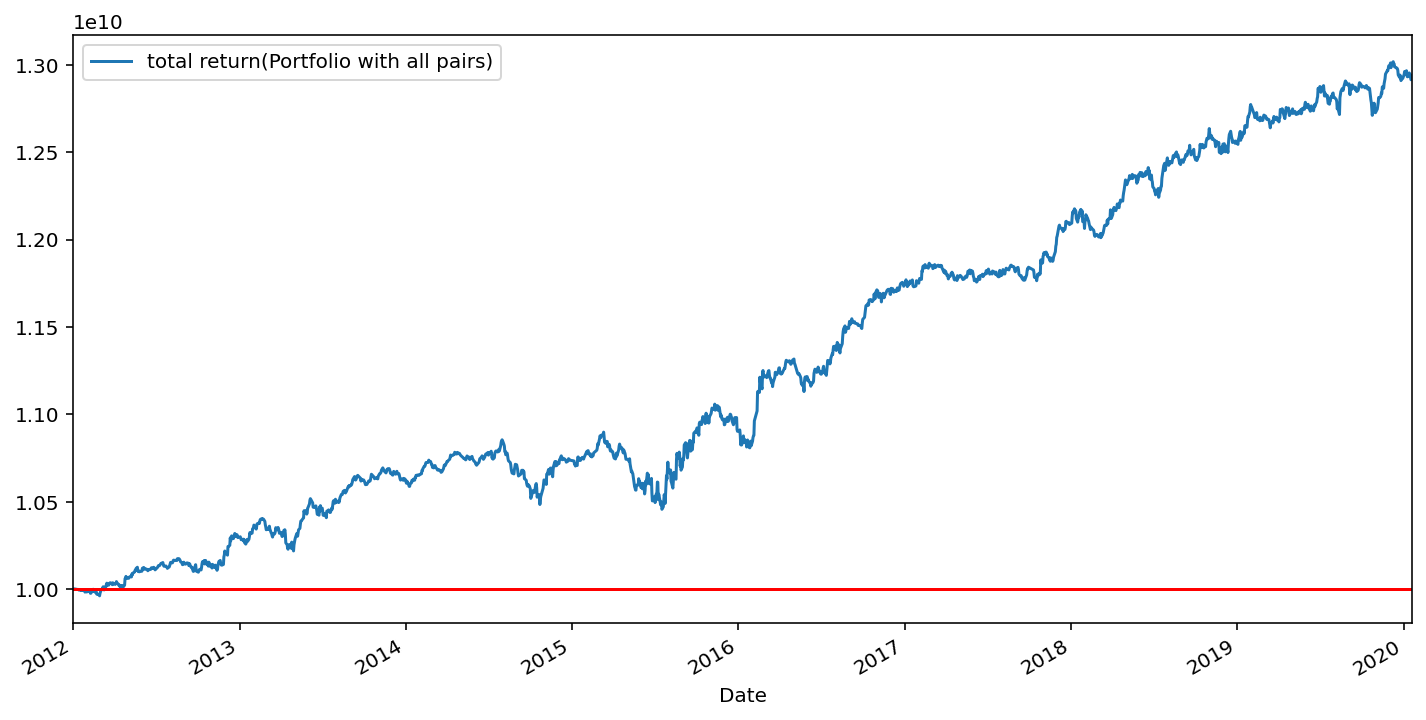

In [180]:
total_df.plot(figsize=(12,6))
plt.axhline(1e10, color='red')
plt.xlim('2012-01-01', '2020-01-20')
plt.legend(['total return(Portfolio with all pairs)'])

## Backtest

### Backtest1(2020~2022)

(737444.0, 738336.0)

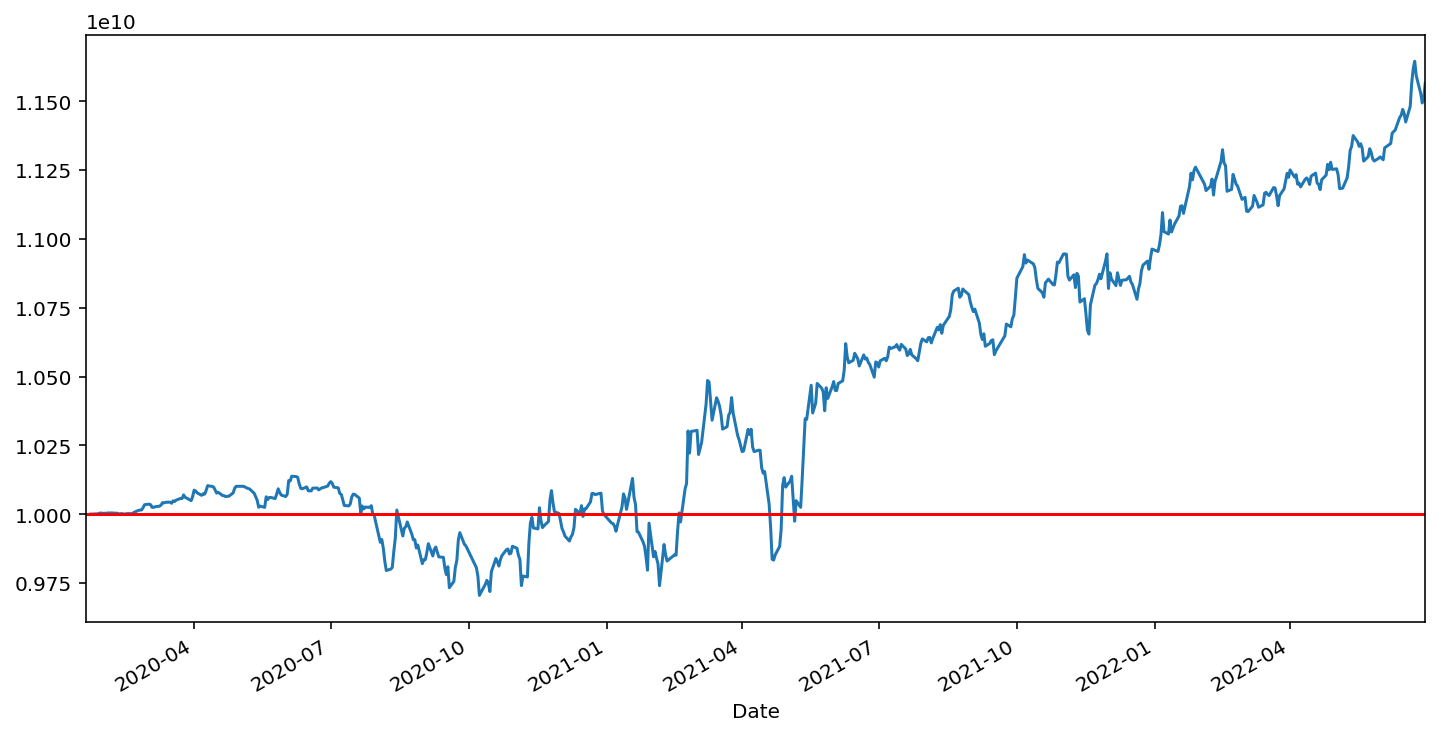

In [181]:
total_df = pair_portfolio_return(pairs, 1, 1e10, train_set=False)

total_df.plot(figsize=(12,6))
plt.axhline(1e10, color='red')
plt.xlim('2020-01-20', '2022-06-30')

## 수익률 시각화

In [182]:
import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [183]:
# use KRX300 as benchmark
benchmark = pd.read_csv('KRX300price.csv', encoding='cp949')
benchmark = benchmark[(benchmark.일자 >= "2012/01/01") & (benchmark.일자 <= '2022/06/30')].reset_index(drop=True)
benchmark = benchmark.종가.pct_change().fillna(0)
benchmark.index = df.index
benchmark.name = 'KRX300'
benchmark.head()

Date
2012-01-02    0.000000
2012-01-03    0.018593
2012-01-04    0.021235
2012-01-05   -0.008076
2012-01-06   -0.013394
Name: KRX300, dtype: float64

### Train

In [184]:
total_df_train = pair_portfolio_return(pairs, 1, 1e10)
returns_train = total_df_train.pct_change()
returns_train.fillna(0, inplace=True)
returns_train.head()

Date
2012-01-04    0.000000
2012-01-05   -0.000038
2012-01-06   -0.000075
2012-01-09   -0.000101
2012-01-10   -0.000095
dtype: float64

In [185]:
returns_train.index = pd.to_datetime(returns_train.index)

In [186]:
start_date = '2012-01-04'
benchmark_train = benchmark[benchmark.index >= start_date]
benchmark_train[start_date] = 0
benchmark_train.head()

Date
2012-01-04    0.000000
2012-01-05   -0.008076
2012-01-06   -0.013394
2012-01-09   -0.022028
2012-01-10    0.008338
Name: KRX300, dtype: float64

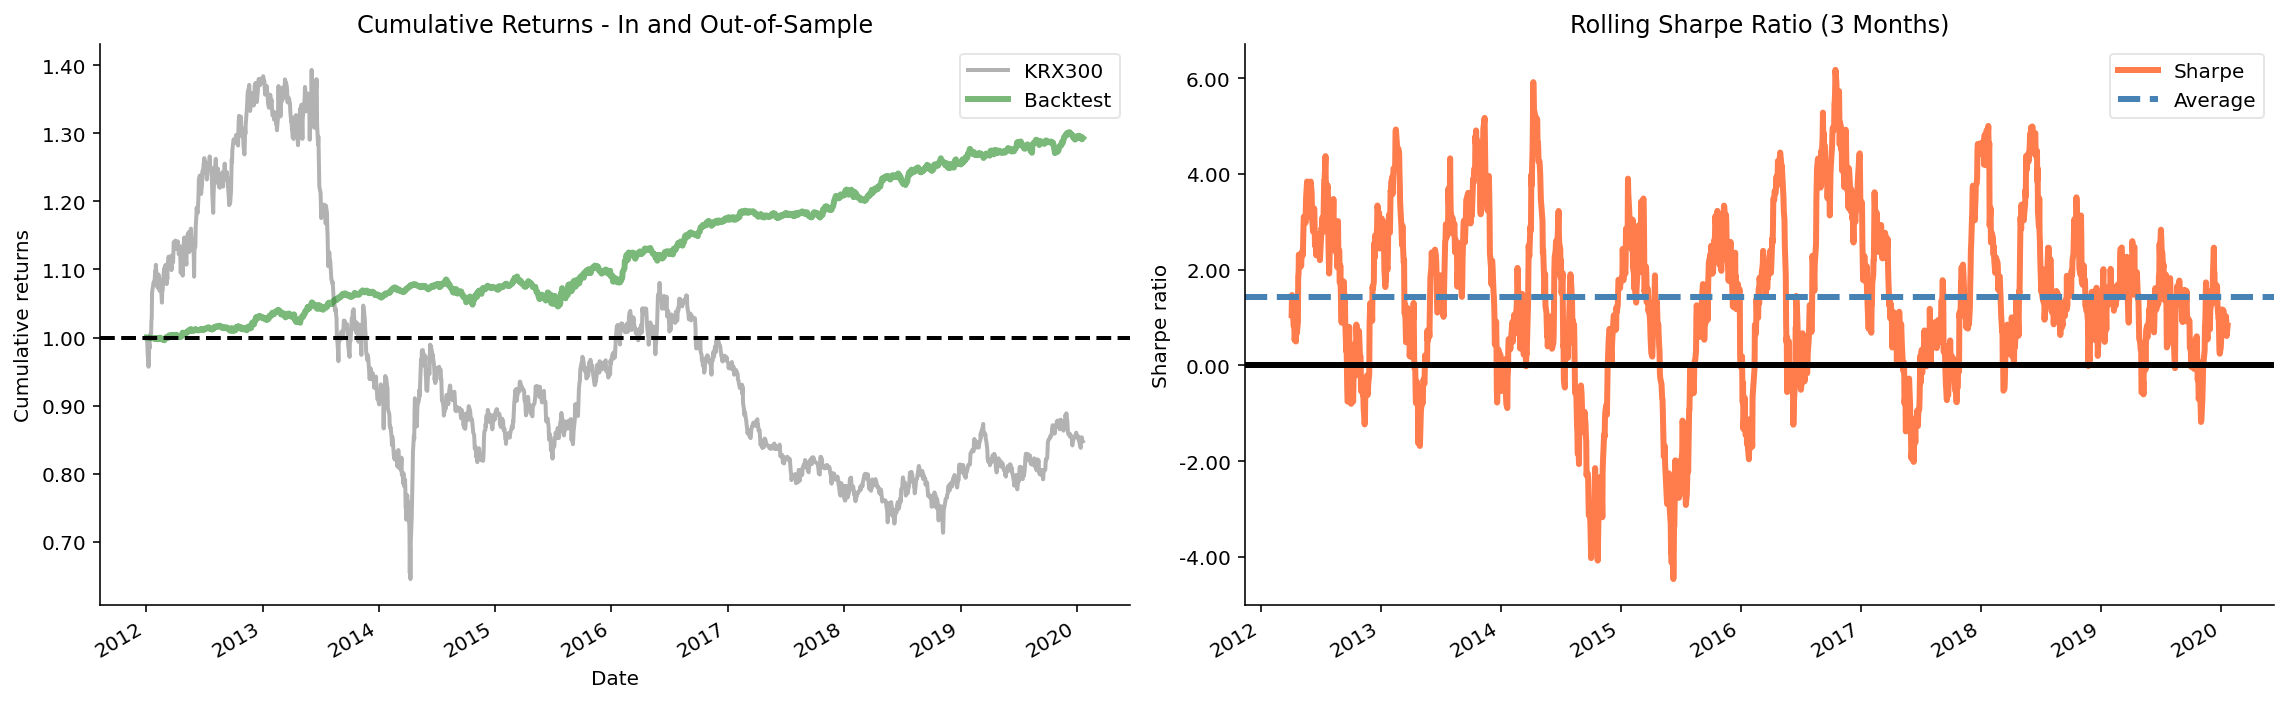

In [187]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns_train,
                     factor_returns=benchmark_train,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(returns_train, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

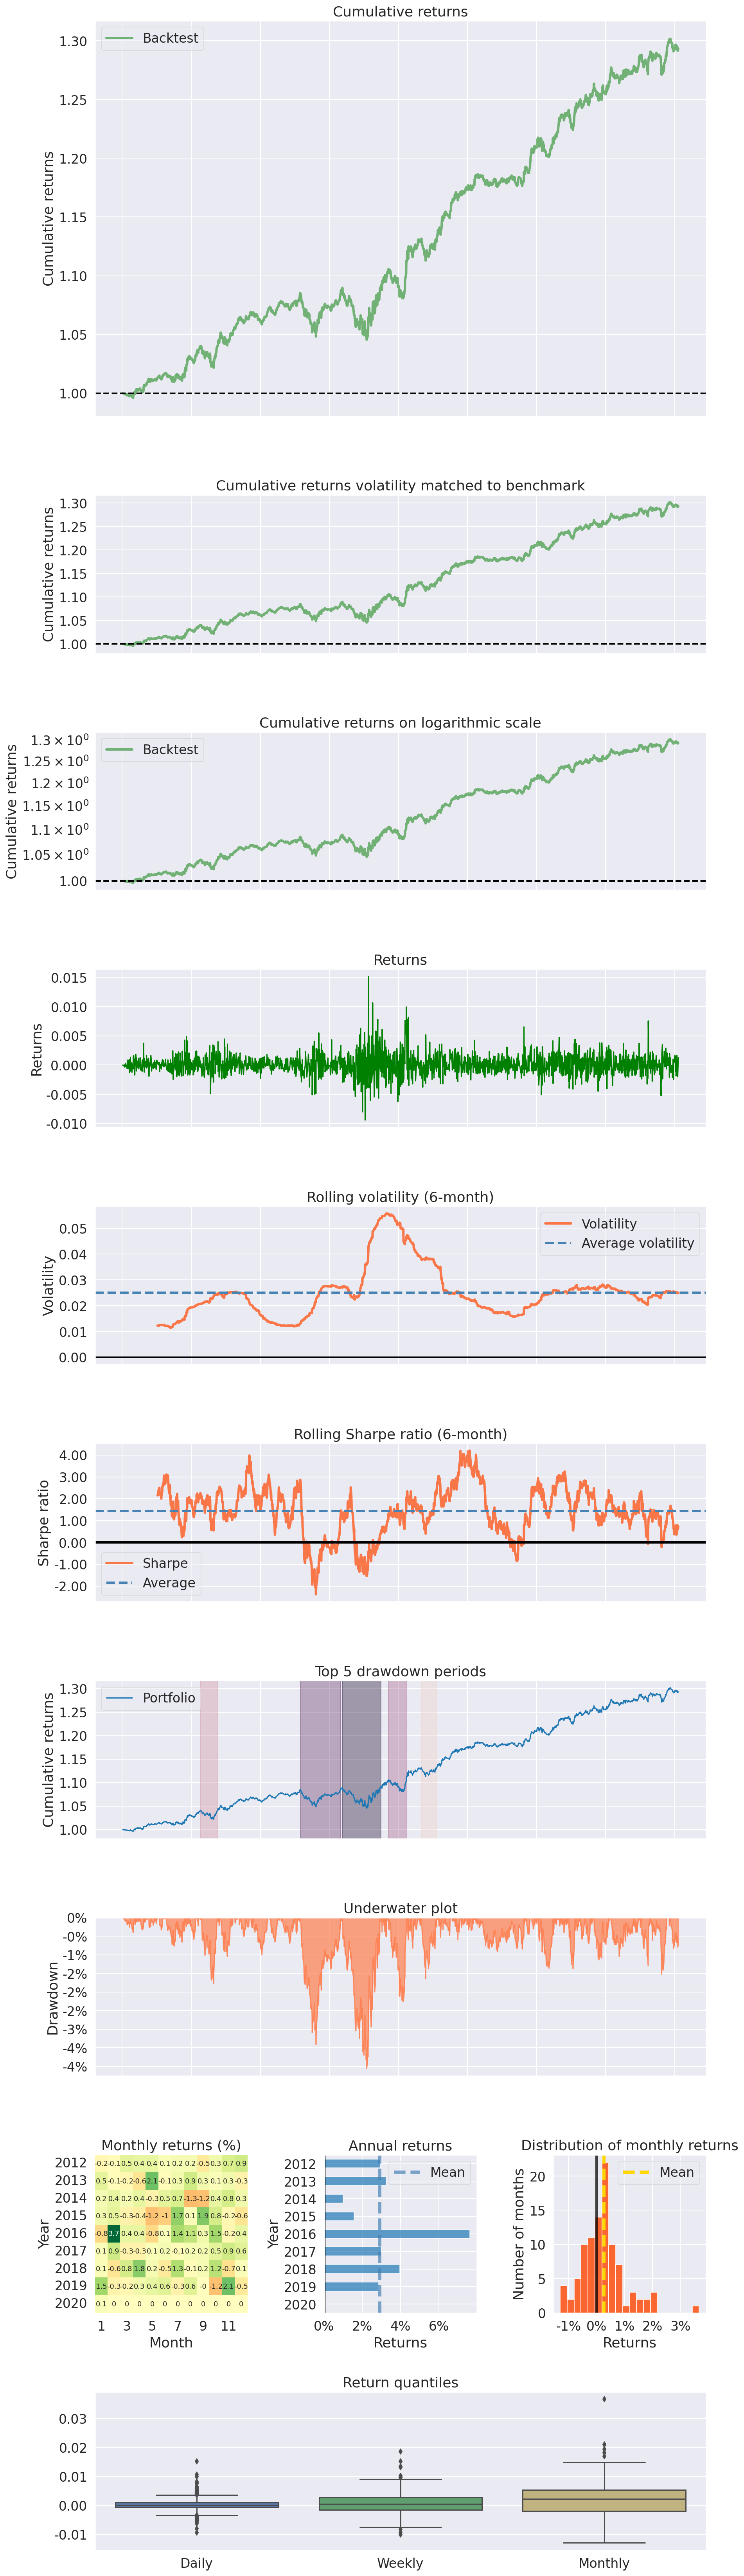

In [188]:
pf.create_returns_tear_sheet(returns_train)

### Test

In [189]:
total_df_test = pair_portfolio_return(pairs, 1, 1e10, train_set=False)
returns_test = total_df_test.pct_change()
returns_test.fillna(0, inplace=True)
returns_test.head()

Date
2020-01-23    0.000000
2020-01-28    0.000116
2020-01-29    0.000237
2020-01-30    0.000034
2020-01-31   -0.000099
dtype: float64

In [190]:
start_date = '2020-01-23'
benchmark_test = benchmark[benchmark.index >= start_date]
benchmark_test[start_date] = 0
benchmark_test.head()

Date
2020-01-23    0.000000
2020-01-28   -0.010653
2020-01-29   -0.000337
2020-01-30    0.006160
2020-01-31   -0.003080
Name: KRX300, dtype: float64

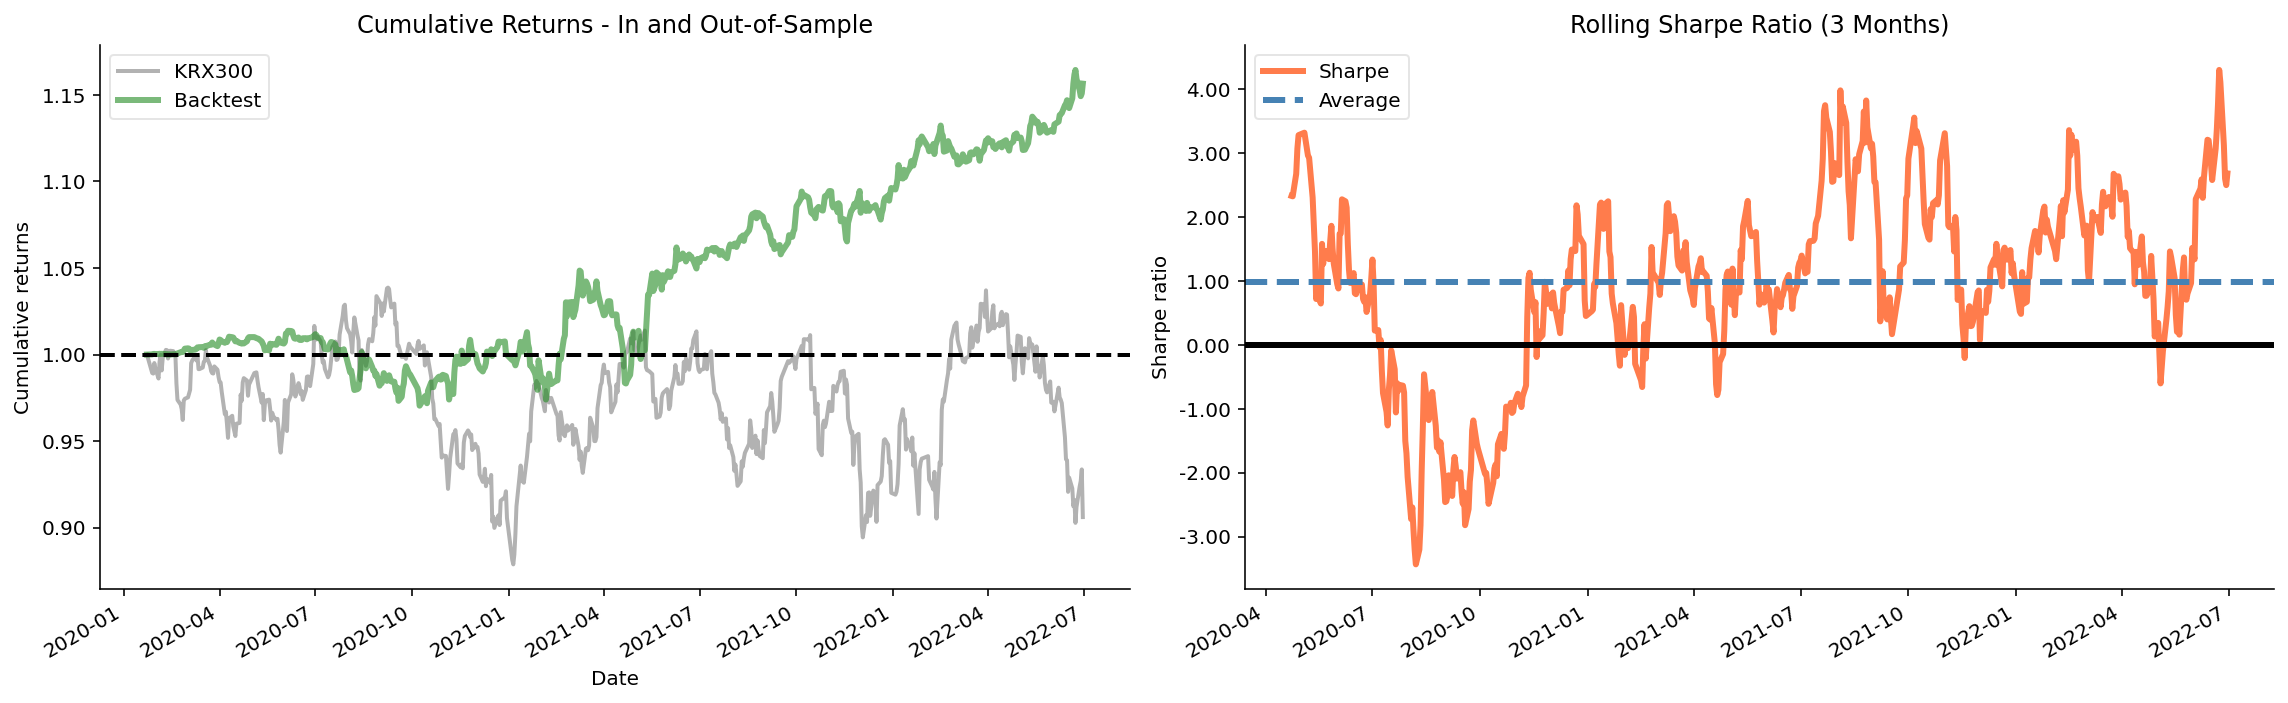

In [191]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns_test,
                     factor_returns=benchmark_test,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(returns_test, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

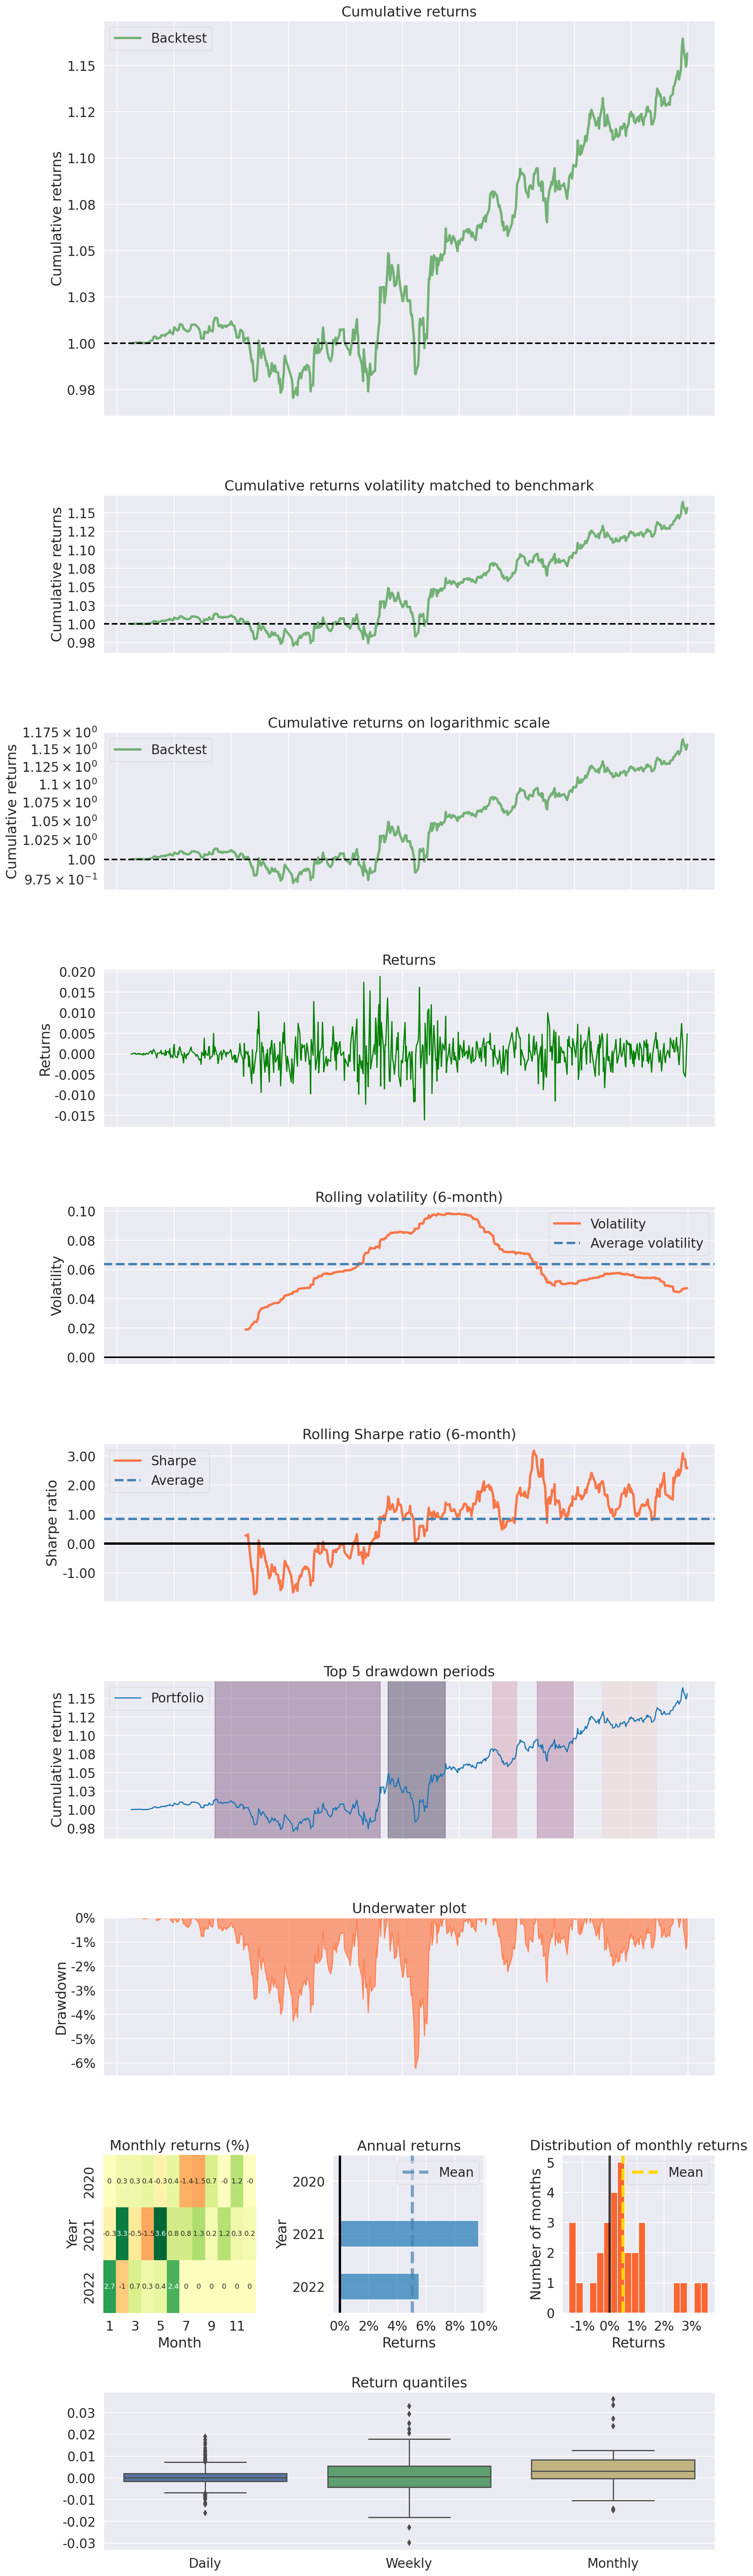

In [192]:
pf.create_returns_tear_sheet(returns_test)

### ALL

In [193]:
test = df

In [194]:
total_df_all = pair_portfolio_return(pairs, 1, 1e10, train_set=False)
returns_all = total_df_all.pct_change()
returns_all.fillna(0, inplace=True)
returns_all.head()

Date
2012-01-04    0.000000
2012-01-05   -0.000218
2012-01-06   -0.000247
2012-01-09   -0.001639
2012-01-10    0.001868
dtype: float64

In [195]:
start_date = '2012-01-04'
benchmark_all = benchmark[benchmark.index >= start_date]
benchmark_all[start_date] = 0
benchmark_all.head()

Date
2012-01-04    0.000000
2012-01-05   -0.008076
2012-01-06   -0.013394
2012-01-09   -0.022028
2012-01-10    0.008338
Name: KRX300, dtype: float64

In [196]:
LIVE_DATE='2020-01-20'

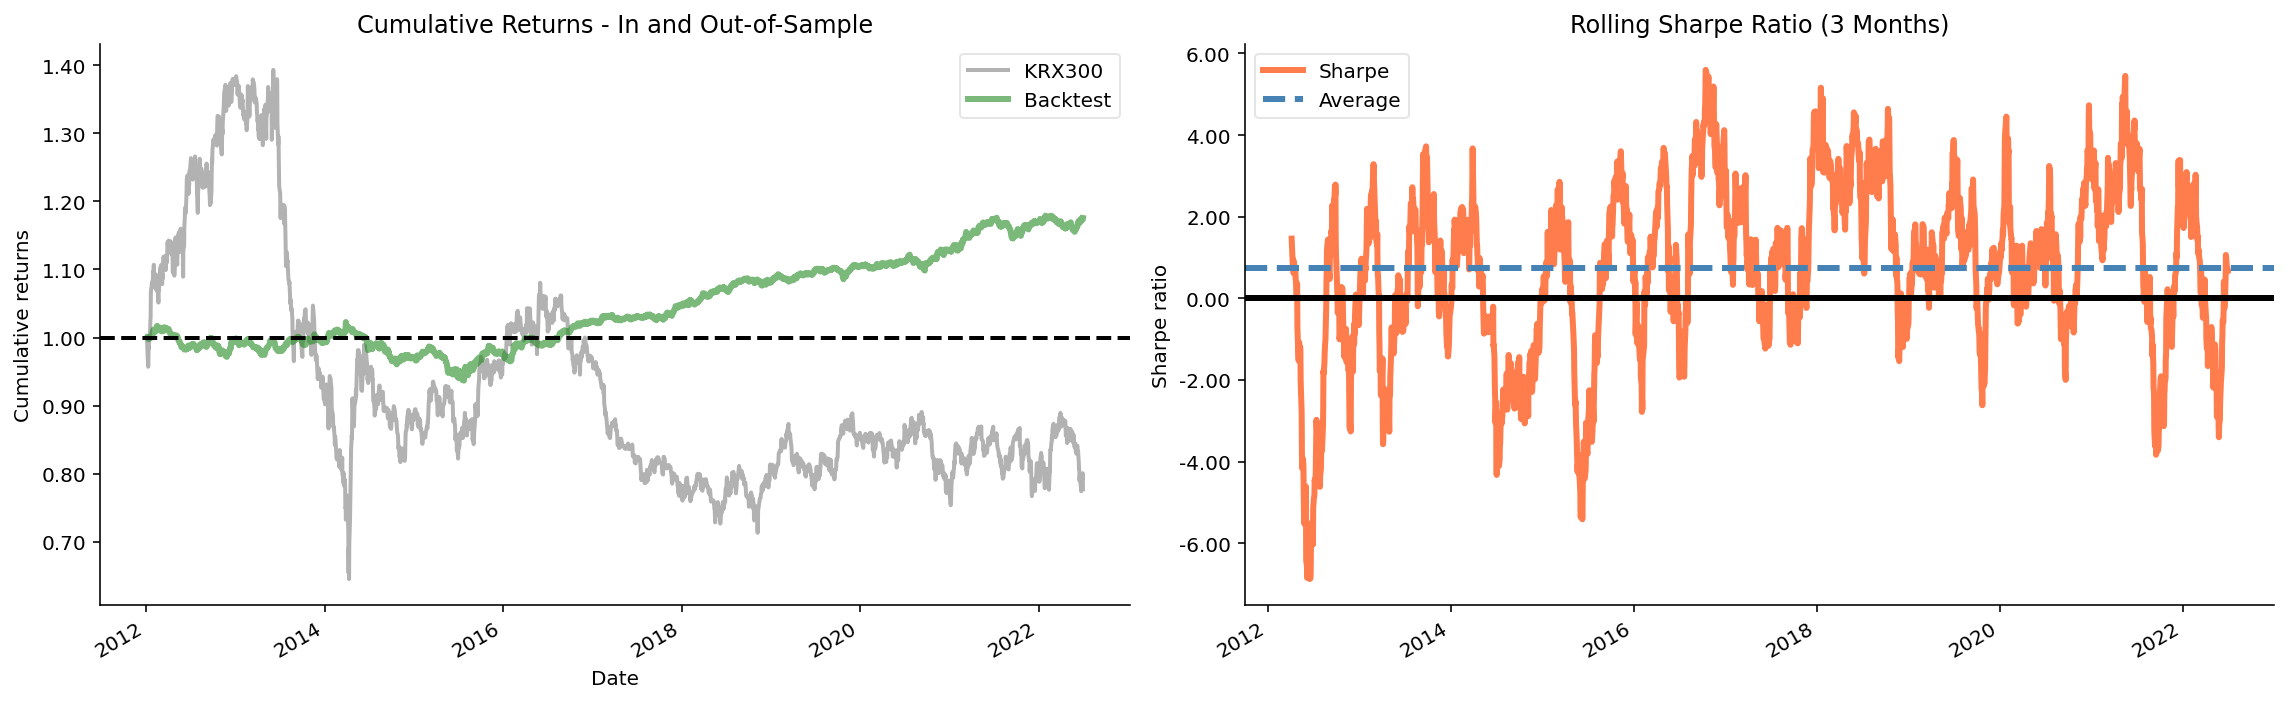

In [197]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns_all,
                     factor_returns=benchmark_all,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns_all, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

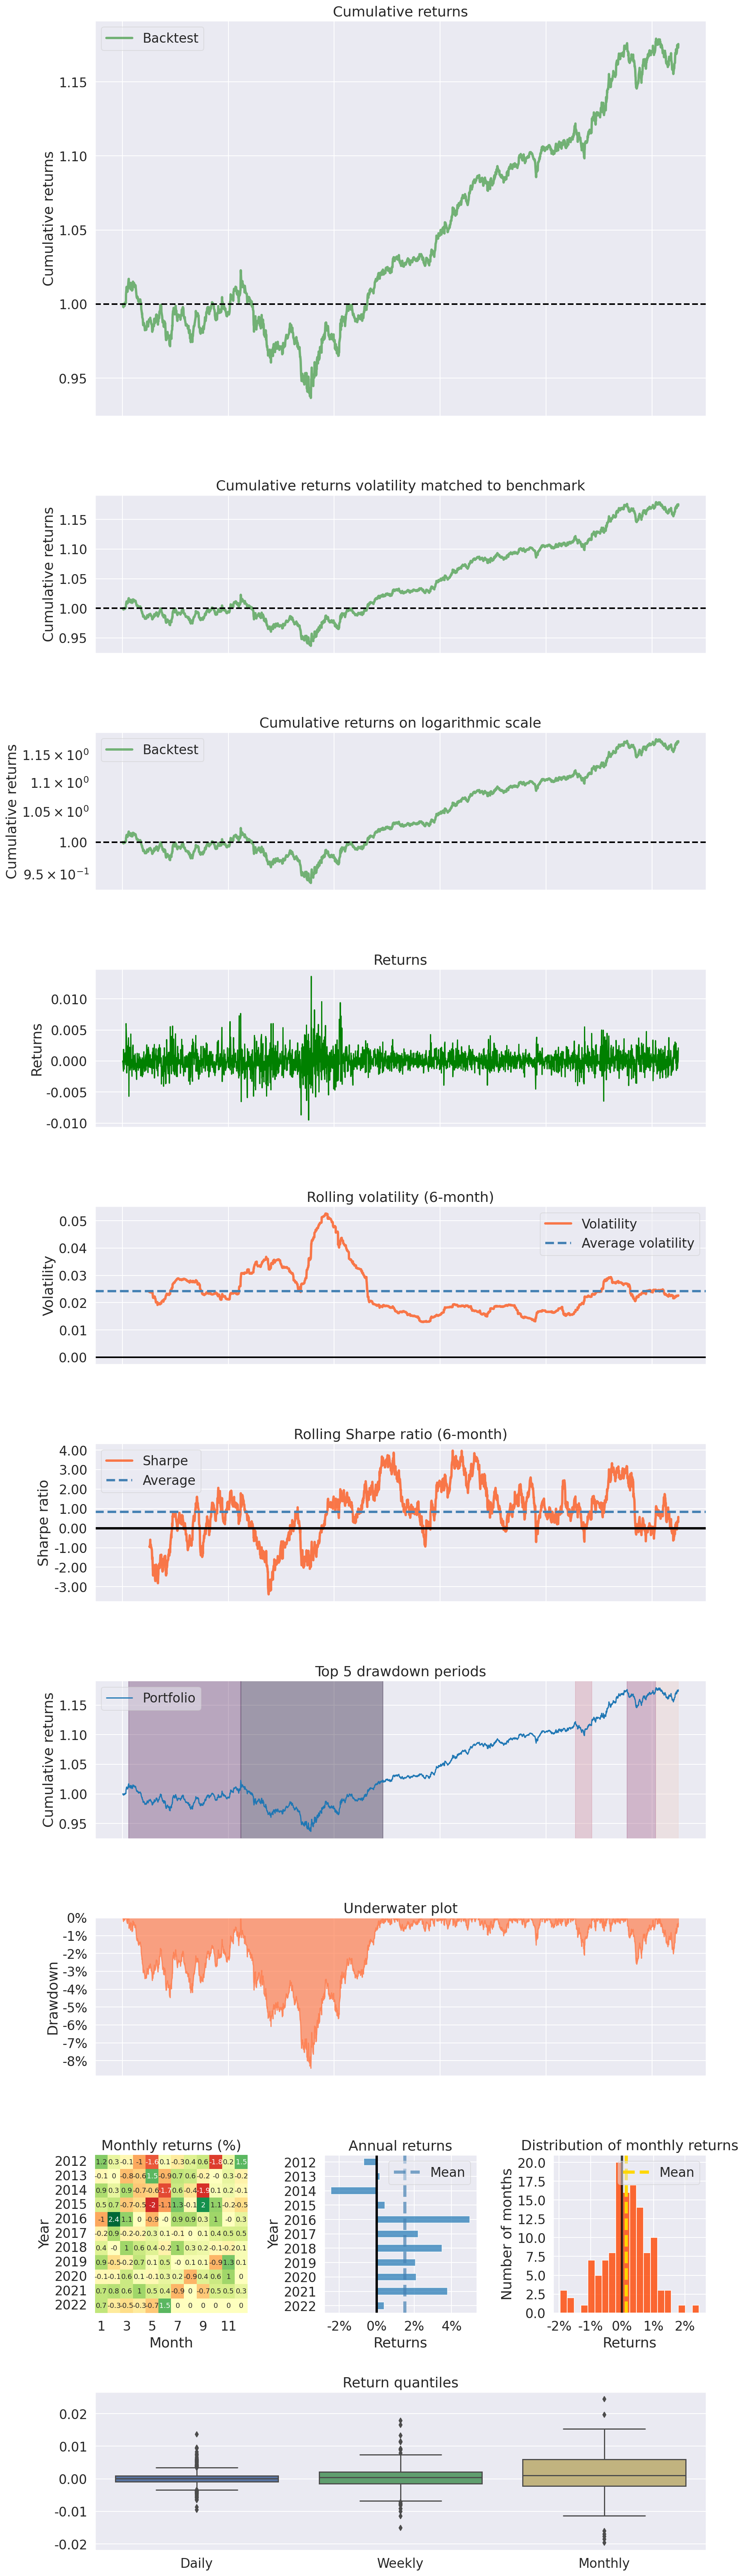

In [198]:
pf.create_returns_tear_sheet(returns_all)